# Introduction

In high-energy physics experiments such as ATLAS at the Large Hadron Collider (LHC), the search for the Higgs boson poses significant challenges due to the overwhelming background and the complexity of the detector response [1]. Modern data-driven approaches, especially those leveraging Artificial Intelligence (AI), offer powerful tools to simulate and extract the subtle signals of the Higgs boson.

In this project, I combine several state-of-the-art methods:

- Synthetic Data Generation with a Conditional Variational Autoencoder (cVAE):

   A cVAE is used to generate synthetic detector data conditioned on event type (signal vs. background). Given the limited availability of real data, this synthetic data serves as an augmentation resource. This model is enhanced with a learned VampPrior [2] (Variational Mixture of Posteriors) and regularized via Maximum Mean Discrepancy (MMD) loss to better capture the complex feature distributions present in real data.

- Physics-Informed Neural Networks (PINNs) for Signal Extraction:

  By incorporating known physical constraints (such as the invariant mass of the decay products being close to 125 GeV) the PINN refines the extraction of the Higgs boson signal. This physics-informed approach helps ensure that the model’s predictions are consistent with theoretical expectations.
  

Throughout this notebook, I detail the architectures, training procedures, and evaluation metrics used in each step. The combined workflow is designed not only to generate high-quality synthetic data but also to robustly detect the Higgs boson signal from complex experimental data.


**NOTE**: This is not a physics-centered notebook since domain knowledge in this field is lacking (and therefore, could be complemented by working with experts in the area), but rather a demonstration on how data science (statistical modeling and artificial intelligence) can help in physics-related tasks to better simulate and identify high-energy particles such as the Higgs Boson, even without being an expert in the subject.

[1] [The Higgs boson: the hunt, the discovery, the study and some future perspectives](https://atlas.cern/updates/feature/higgs-boson)
[2] [VAE with a VampPrior](https://arxiv.org/abs/1705.07120)



# Loading the Data

The data comes from a Kaggle Challenge [1] and it is composed of 30 features and a target variable (Label) that classifies the datapoints as signal or background. The features are:

- **EventId**: An unique integer identifier of the event. Not to be used as a feature.
- **DER mass MMC**: The estimated mass \(m_H\) of the Higgs boson candidate.
- **DER mass transverse met lep**: The transverse mass between the missing transverse energy and the lepton.
- **DER mass vis**: The invariant mass of the hadronic tau and the lepton.
- **DER pt h**: The modulus of the vector sum of the transverse momentum of the hadronic tau, the lepton, and the missing transverse energy vector.
- **DER deltaeta jet jet**: The absolute value of the pseudorapidity separation between the two jets (undefined if \(PRI\_jet\_num = 1\)).
- **DER mass jet jet**: The invariant mass of the two jets (undefined if \(PRI\_jet\_num = 1\)).
- **DER prodeta jet jet**: The product of the pseudorapidities of the two jets (undefined if \(PRI\_jet\_num = 1\)).
- **DER deltar tau lep**: The \(R\) separation between the hadronic tau and the lepton.
- **DER pt tot**: The modulus of the vector sum of the missing transverse momenta and the transverse momenta of the hadronic tau, the lepton, the leading jet (if \(PRI\_jet\_num = 1\)), and the subleading jet (if \(PRI\_jet\_num = 2\)) (but not of any additional jets).
- **DER sum pt**: The sum of the moduli of the transverse momenta of the hadronic tau, the lepton, the leading jet (if \(PRI\_jet\_num = 1\)), and the other jets (if \(PRI\_jet\_num > 1\)) and the subleading jet (if \(PRI\_jet\_num = 3\)).
- **DER pt ratio lep tau**: The ratio of the transverse momenta of the lepton and the hadronic tau.
- **DER metphi centrality**: The centrality of the azimuthal angle of the missing transverse energy vector with respect to the hadronic tau and the lepton.
- **DER lepeta centrality**: The centrality of the pseudorapidity of the lepton with respect to the two jets (undefined if \(PRI\_jet\_num = 1\)).
- **PRI taupt**: The transverse momentum of the hadronic tau.
- **PRI taueta**: The pseudorapidity of the hadronic tau.
- **PRI tauphi**: The azimuth angle of the hadronic tau.
- **PRI leppt**: The transverse momentum of the lepton (electron or muon).
- **PRI lepeta**: The pseudorapidity of the lepton.
- **PRI lepphi**: The azimuth angle of the lepton.
- **PRI met**: The missing transverse energy.
- **PRI metphi**: The azimuth angle of the missing transverse energy.
- **PRI metsumet**: The total transverse energy in the detector.
- **PRI jet num**: The number of jets (integer with value of 0, 1, 2 or 3; possible larger values have been capped at 3).
- **PRI jet leadingpt**: The transverse momentum of the leading jet, that is the jet with the largest transverse momentum (undefined if \(PRI\_jet\_num = 0\)).
- **PRI jet leadingeta**: The pseudorapidity of the leading jet (undefined if \(PRI\_jet\_num = 0\)).
- **PRI jet leadingphi**: The azimuth angle of the leading jet (undefined if \(PRI\_jet\_num = 0\)).
- **PRI jet subleadingpt**: The transverse momentum of the leading jet, that is, the jet with the second largest transverse momentum (undefined if \(PRI\_jet\_num $\leq$ 1\)).
- **PRI jet subleadingeta**: The pseudorapidity of the subleading jet (undefined if \(PRI\_jet\_num $\leq$ 1\)).
- **PRI jet subleadingphi**: The azimuth angle of the subleading jet (undefined if \(PRI\_jet\_num $\leq$ 1\)).
- **PRI jet all pt**: The scalar sum of the transverse momentum of all the jets of the events.
- **Weight**: The event weight, not to be used as a feature. Not available in the test sample.
- **Label**: The event label (string), "s" for signal, "b" for background. Not to be used as a feature. Not available in the test sample.


[1] [Higgs Boson Machine Learning Challenge](https://www.kaggle.com/c/higgs-boson/data)

In [1]:
''' Uploads account credentials to Kaggle '''

# from google.colab import files
# files.upload()


' Uploads account credentials to Kaggle '

In [2]:
# Extract and sets the correct location in the directory
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [3]:
# Install Kaggle dependencies
!pip install kaggle

In [4]:
# Download the Higgs Boson dataset using the Kaggle API:
!kaggle competitions download -c higgs-boson

 96% 52.0M/54.3M [00:03<00:00, 23.8MB/s]
100% 54.3M/54.3M [00:03<00:00, 16.6MB/s]


In [5]:
# Unzip the file
!unzip higgs-boson.zip -d higgs_boson_data

Archive:  higgs-boson.zip
  inflating: higgs_boson_data/HiggsBosonCompetition_AMSMetric_rev1.py  
  inflating: higgs_boson_data/random_submission.zip  
  inflating: higgs_boson_data/test.zip  
  inflating: higgs_boson_data/training.zip  


In [6]:
import zipfile
import os
import pandas as pd

# set path
extract_path = 'higgs_boson_data'
training_zip = 'training.zip'
test_zip = 'test.zip'
training_file_path = os.path.join(extract_path, training_zip)
test_file_path = os.path.join(extract_path, test_zip)

# decompress training data
with zipfile.ZipFile(training_file_path, 'r') as zip_ref:
    zip_ref.extractall(training_zip)

# decompress test data
with zipfile.ZipFile(test_file_path, 'r') as zip_ref:
    zip_ref.extractall(test_zip)

In [7]:
# Read training set
training_higghs_boson_data_original = pd.read_csv('training.zip/training.csv')
training_higghs_boson_data_original

,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight,Label
0,100000,138.470,51.655,97.827,27.980,0.91,124.711,2.666,3.064,41.928,...,2,67.435,2.150,0.444,46.062,1.24,-2.475,113.497,0.002653,s
1,100001,160.937,68.768,103.235,48.146,-999.00,-999.000,-999.000,3.473,2.078,...,1,46.226,0.725,1.158,-999.000,-999.00,-999.000,46.226,2.233584,b
2,100002,-999.000,162.172,125.953,35.635,-999.00,-999.000,-999.000,3.148,9.336,...,1,44.251,2.053,-2.028,-999.000,-999.00,-999.000,44.251,2.347389,b
3,100003,143.905,81.417,80.943,0.414,-999.00,-999.000,-999.000,3.310,0.414,...,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,-0.000,5.446378,b
4,100004,175.864,16.915,134.805,16.405,-999.00,-999.000,-999.000,3.891,16.405,...,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,0.000,6.245333,b
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249995,349995,-999.000,71.989,36.548,5.042,-999.00,-999.000,-999.000,1.392,5.042,...,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,0.000,4.505083,b
249996,349996,-999.000,58.179,68.083,22.439,-999.00,-999.000,-999.000,2.585,22.439,...,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,-0.000,2.497259,b
249997,349997,105.457,60.526,75.839,39.757,-999.00,-999.000,-999.000,2.390,22.183,...,1,41.992,1.800,-0.166,-999.000,-999.00,-999.000,41.992,0.018636,s
249998,349998,94.951,19.362,68.812,13.504,-999.00,-999.000,-999.000,3.365,13.504,...,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,0.000,1.681611,b


In [8]:
# Read test set
test_higghs_boson_data = pd.read_csv('test.zip/test.csv')
test_higghs_boson_data

,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt
0,350000,-999.000,79.589,23.916,3.036,-999.000,-999.000,-999.000,0.903,3.036,...,2.022,98.556,0,-999.000,-999.000,-999.000,-999.000,-999.000,-999.000,-0.000
1,350001,106.398,67.490,87.949,49.994,-999.000,-999.000,-999.000,2.048,2.679,...,-1.138,176.251,1,47.575,-0.553,-0.849,-999.000,-999.000,-999.000,47.575
2,350002,117.794,56.226,96.358,4.137,-999.000,-999.000,-999.000,2.755,4.137,...,-1.868,111.505,0,-999.000,-999.000,-999.000,-999.000,-999.000,-999.000,0.000
3,350003,135.861,30.604,97.288,9.104,-999.000,-999.000,-999.000,2.811,9.104,...,1.172,164.707,0,-999.000,-999.000,-999.000,-999.000,-999.000,-999.000,0.000
4,350004,74.159,82.772,58.731,89.646,1.347,536.663,-0.339,1.028,77.213,...,-0.231,869.614,3,254.085,-1.013,-0.334,185.857,0.335,2.587,599.213
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
549995,899995,309.530,28.185,170.795,99.349,-999.000,-999.000,-999.000,3.061,2.367,...,1.956,177.103,1,97.451,-1.759,-0.733,-999.000,-999.000,-999.000,97.451
549996,899996,105.653,5.096,77.256,33.040,-999.000,-999.000,-999.000,2.693,33.040,...,-0.172,130.730,0,-999.000,-999.000,-999.000,-999.000,-999.000,-999.000,-0.000
549997,899997,-999.000,69.470,51.766,1.189,-999.000,-999.000,-999.000,1.615,1.189,...,0.336,71.646,0,-999.000,-999.000,-999.000,-999.000,-999.000,-999.000,-0.000
549998,899998,107.254,13.500,79.833,50.801,-999.000,-999.000,-999.000,2.026,7.993,...,-0.988,243.371,1,43.099,-0.352,-2.594,-999.000,-999.000,-999.000,43.099


In [9]:
# Inspect variables and data
training_higghs_boson_data_original.info()
test_higghs_boson_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 33 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   EventId                      250000 non-null  int64  
 1   DER_mass_MMC                 250000 non-null  float64
 2   DER_mass_transverse_met_lep  250000 non-null  float64
 3   DER_mass_vis                 250000 non-null  float64
 4   DER_pt_h                     250000 non-null  float64
 5   DER_deltaeta_jet_jet         250000 non-null  float64
 6   DER_mass_jet_jet             250000 non-null  float64
 7   DER_prodeta_jet_jet          250000 non-null  float64
 8   DER_deltar_tau_lep           250000 non-null  float64
 9   DER_pt_tot                   250000 non-null  float64
 10  DER_sum_pt                   250000 non-null  float64
 11  DER_pt_ratio_lep_tau         250000 non-null  float64
 12  DER_met_phi_centrality       250000 non-null  float64
 13 

In [10]:
# Summary statistics for the training set
training_higghs_boson_data_original.describe()

,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight
count,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,...,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000
mean,224999.500000,-49.023079,49.239819,81.181982,57.895962,-708.420675,-601.237051,-709.356603,2.373100,18.917332,...,209.797178,0.979176,-348.329567,-399.254314,-399.259788,-692.381204,-709.121609,-709.118631,73.064591,1.646767
std,72168.927986,406.345647,35.344886,40.828691,63.655682,454.480565,657.972302,453.019877,0.782911,22.273494,...,126.499506,0.977426,532.962789,489.338286,489.333883,479.875496,453.384624,453.389017,98.015662,1.875103
min,100000.000000,-999.000000,0.000000,6.329000,0.000000,-999.000000,-999.000000,-999.000000,0.208000,0.000000,...,13.678000,0.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,0.000000,0.001502
25%,162499.750000,78.100750,19.241000,59.388750,14.068750,-999.000000,-999.000000,-999.000000,1.810000,2.841000,...,123.017500,0.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-0.000000,0.018636
50%,224999.500000,105.012000,46.524000,73.752000,38.467500,-999.000000,-999.000000,-999.000000,2.491500,12.315500,...,179.739000,1.000000,38.960000,-1.872000,-2.093000,-999.000000,-999.000000,-999.000000,40.512500,1.156188
75%,287499.250000,130.606250,73.598000,92.259000,79.169000,0.490000,83.446000,-4.593000,2.961000,27.591000,...,263.379250,2.000000,75.349000,0.433000,0.503000,33.703000,-2.457000,-2.275000,109.933750,2.404128
max,349999.000000,1192.026000,690.075000,1349.351000,2834.999000,8.503000,4974.979000,16.690000,5.684000,2834.999000,...,2003.976000,3.000000,1120.573000,4.499000,3.141000,721.456000,4.500000,3.142000,1633.433000,7.822543


In [11]:
# Summary statistics for the test set
test_higghs_boson_data.describe()

,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt
count,550000.000000,550000.000000,550000.000000,550000.000000,550000.000000,550000.000000,550000.000000,550000.000000,550000.000000,550000.000000,...,550000.000000,550000.000000,550000.000000,550000.000000,550000.000000,550000.000000,550000.000000,550000.000000,550000.000000,550000.000000
mean,624999.500000,-48.950144,49.261093,81.123904,57.824801,-707.448878,-599.705905,-708.391425,2.374076,18.988277,...,-0.008214,209.933695,0.980171,-348.946684,-399.883839,-399.896234,-691.309277,-708.150605,-708.153058,73.248856
std,158771.468364,406.233686,35.425422,40.435560,63.291314,454.928791,659.129589,453.461222,0.779895,21.767376,...,1.812777,126.910079,0.979271,533.155176,489.467786,489.457747,480.435230,453.834190,453.830095,98.467134
min,350000.000000,-999.000000,0.000000,6.810000,0.000000,-999.000000,-999.000000,-999.000000,0.237000,0.000000,...,-3.142000,13.847000,0.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-0.000000
25%,487499.750000,78.167750,19.313000,59.422000,14.192000,-999.000000,-999.000000,-999.000000,1.815000,2.838000,...,-1.574000,122.984750,0.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,0.000000
50%,624999.500000,105.076000,46.455500,73.747000,38.469500,-999.000000,-999.000000,-999.000000,2.492000,12.390000,...,-0.017000,179.949000,1.000000,38.970000,-1.862000,-2.111000,-999.000000,-999.000000,-999.000000,40.503500
75%,762499.250000,130.769000,73.646000,92.173000,79.234250,0.503000,84.266250,-4.538000,2.962000,27.649000,...,1.558000,263.917250,2.000000,75.499000,0.431000,0.484000,33.832000,-2.429000,-2.260000,110.507000
max,899999.000000,1949.261000,968.669000,1264.965000,1337.187000,8.724000,4794.827000,17.294000,5.751000,759.363000,...,3.142000,2190.275000,3.000000,1163.439000,4.500000,3.142000,817.801000,4.500000,3.142000,1860.175000


In [12]:
# Making a copy to avoid modifyin original data
training_higghs_boson_data = training_higghs_boson_data_original.copy()

# Exctarct features (30 features)
predicted_features = training_higghs_boson_data.iloc[:,-2:]

# Ignore EventId, Weight and Label
columns_to_ignore = [training_higghs_boson_data.columns[0]] + list(predicted_features.columns)

# List of 30 features
feature_cols = [col for col in training_higghs_boson_data.columns if col not in columns_to_ignore]

# See dataset with the 30 features
training_higghs_boson_data[feature_cols]

,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,...,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt
0,138.470,51.655,97.827,27.980,0.91,124.711,2.666,3.064,41.928,197.760,...,-0.277,258.733,2,67.435,2.150,0.444,46.062,1.24,-2.475,113.497
1,160.937,68.768,103.235,48.146,-999.00,-999.000,-999.000,3.473,2.078,125.157,...,-1.916,164.546,1,46.226,0.725,1.158,-999.000,-999.00,-999.000,46.226
2,-999.000,162.172,125.953,35.635,-999.00,-999.000,-999.000,3.148,9.336,197.814,...,-2.186,260.414,1,44.251,2.053,-2.028,-999.000,-999.00,-999.000,44.251
3,143.905,81.417,80.943,0.414,-999.00,-999.000,-999.000,3.310,0.414,75.968,...,0.060,86.062,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,-0.000
4,175.864,16.915,134.805,16.405,-999.00,-999.000,-999.000,3.891,16.405,57.983,...,-0.871,53.131,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249995,-999.000,71.989,36.548,5.042,-999.00,-999.000,-999.000,1.392,5.042,55.892,...,2.859,144.665,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,0.000
249996,-999.000,58.179,68.083,22.439,-999.00,-999.000,-999.000,2.585,22.439,50.618,...,-0.867,80.408,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,-0.000
249997,105.457,60.526,75.839,39.757,-999.00,-999.000,-999.000,2.390,22.183,120.462,...,-2.890,198.907,1,41.992,1.800,-0.166,-999.000,-999.00,-999.000,41.992
249998,94.951,19.362,68.812,13.504,-999.00,-999.000,-999.000,3.365,13.504,55.859,...,0.811,112.718,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,0.000


In [13]:
# One-hot encode the Label (target variable)

import pandas as pd
from sklearn.preprocessing import OneHotEncoder



# Setting OneHotEncoder object
one_hot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# Fit the encoder on the 'Label' column
encoded_labels = one_hot_encoder.fit_transform(training_higghs_boson_data[['Label']])

# Create a new DataFrame with the one-hot encoded labels
encoded_df = pd.DataFrame(encoded_labels, columns=one_hot_encoder.get_feature_names_out(['Label']))
encoded_df

,Label_b,Label_s
0,0.0,1.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
...,...,...
249995,1.0,0.0
249996,1.0,0.0
249997,0.0,1.0
249998,1.0,0.0


In [14]:
# Normalize 30 features

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler


scaler = MinMaxScaler(feature_range=(0,1))
training_higghs_boson_data[feature_cols] = scaler.fit_transform(training_higghs_boson_data[feature_cols])
training_higghs_boson_data

,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight,Label
0,100000,0.519149,0.074854,0.068128,0.009869,0.992464,0.188101,0.986193,0.521549,0.014789,...,0.666667,0.503137,0.997659,0.997309,0.607433,0.996751,0.994395,0.069484,0.002653,s
1,100001,0.529404,0.099653,0.072155,0.016983,0.000000,0.000000,0.000000,0.596238,0.000733,...,0.333333,0.493130,0.996239,0.998021,0.000000,0.000000,0.000000,0.028300,2.233584,b
2,100002,0.000000,0.235006,0.089071,0.012570,0.000000,0.000000,0.000000,0.536888,0.003293,...,0.333333,0.492199,0.997563,0.994842,0.000000,0.000000,0.000000,0.027091,2.347389,b
3,100003,0.521630,0.117983,0.055557,0.000146,0.000000,0.000000,0.000000,0.566472,0.000146,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.446378,b
4,100004,0.536216,0.024512,0.095662,0.005787,0.000000,0.000000,0.000000,0.672571,0.005787,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.245333,b
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249995,349995,0.000000,0.104321,0.022501,0.001778,0.000000,0.000000,0.000000,0.216216,0.001778,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.505083,b
249996,349996,0.000000,0.084308,0.045981,0.007915,0.000000,0.000000,0.000000,0.434076,0.007915,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.497259,b
249997,349997,0.504082,0.087709,0.051756,0.014024,0.000000,0.000000,0.000000,0.398466,0.007825,...,0.333333,0.491133,0.997310,0.996700,0.000000,0.000000,0.000000,0.025708,0.018636,s
249998,349998,0.499287,0.028058,0.046524,0.004763,0.000000,0.000000,0.000000,0.576516,0.004763,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.681611,b


In [15]:
# Combine the normalized 30 features with the one-hot encoded label
training_higghs_boson_data = pd.concat([training_higghs_boson_data, encoded_df], axis=1).drop(columns=['EventId','Weight','Label'])
training_higghs_boson_data

,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,...,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Label_b,Label_s
0,0.519149,0.074854,0.068128,0.009869,0.992464,0.188101,0.986193,0.521549,0.014789,0.083957,...,0.666667,0.503137,0.997659,0.997309,0.607433,0.996751,0.994395,0.069484,0.0,1.0
1,0.529404,0.099653,0.072155,0.016983,0.000000,0.000000,0.000000,0.596238,0.000733,0.043764,...,0.333333,0.493130,0.996239,0.998021,0.000000,0.000000,0.000000,0.028300,1.0,0.0
2,0.000000,0.235006,0.089071,0.012570,0.000000,0.000000,0.000000,0.536888,0.003293,0.083987,...,0.333333,0.492199,0.997563,0.994842,0.000000,0.000000,0.000000,0.027091,1.0,0.0
3,0.521630,0.117983,0.055557,0.000146,0.000000,0.000000,0.000000,0.566472,0.000146,0.016533,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0
4,0.536216,0.024512,0.095662,0.005787,0.000000,0.000000,0.000000,0.672571,0.005787,0.006576,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249995,0.000000,0.104321,0.022501,0.001778,0.000000,0.000000,0.000000,0.216216,0.001778,0.005419,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0
249996,0.000000,0.084308,0.045981,0.007915,0.000000,0.000000,0.000000,0.434076,0.007915,0.002499,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0
249997,0.504082,0.087709,0.051756,0.014024,0.000000,0.000000,0.000000,0.398466,0.007825,0.041165,...,0.333333,0.491133,0.997310,0.996700,0.000000,0.000000,0.000000,0.025708,0.0,1.0
249998,0.499287,0.028058,0.046524,0.004763,0.000000,0.000000,0.000000,0.576516,0.004763,0.005400,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0


In [16]:
import numpy as np

data_dim = len(feature_cols[:-2])  # number of features in the dataset
latent_dim = 100             # dimension of the latent space

# Conditional VampPrior $\beta$-Variational Auto Encoder

Training a model on big datasets can help it to better learn patterns and thus, predict better outputs, however, data collection can be sometimes difficult and costly, therefore, methods for creating synthetic data have emerged over the last years. In this case, for the data generation process, I relied on a Conditional Variational Mixture of Posteriors Prior β-Variational Autoencoder (cVampPrior β-VAE) to enrcih the current available dataset. The reason behind this is an that this is an unsupervised method known for its flexibility to learn the general patterns of the inputs (encode) and then reconstruct them (decode) to generate new datasets based on a condition that closely matches the true distribution of the unerlying dataset.

Let's explain it by parts:

A standard Variational Autoencoder (VAE) [1] is a model used to learn the underlying distributions of the input data (prior) and minimize its reconstruction for the data generation (posterior) resembling the original dataset. This is given by the Kullback-Leibler (KL) Divergence which is calculated thanks to the Evidence Lower Bound (ELBO) [2] and regularized by a $\beta$ term to control the influence on the total reconstruction loss, given a final definition as follows:

\begin{align*}
\mathcal{L}(x) = \mathbb{E}_{q_{\phi}(z|x)} \left[ \log p_{\theta}(x|z) \right] - \beta D_{\mathrm{KL}} \left( q_{\phi}(z|x) \| p_{\theta}(z) \right)
\end{align*}

where:

- $\mathbb{E}_{q_{\phi}(z|x)} \left[ \log p_{\theta}(x|z) \right]$ =Reconstruction term, composed by:

  - $ \mathbb{E}_{q_{\phi}(z|x)} $ = Expected posterior given a latent prior z

  - $\log p_{\theta}(x|z)$ = decoder that reconstructs the data from a latent representation z obtained form a posterior given x

- $D_{\mathrm{KL}} \left(q_{\phi}(z|x) \| p_{\theta}(z)\right)$ = The actual KL divergence that checks how much the posterior q(z|x) deviates form the prior p(z) and keep it as close as possible to the prior

- $\beta$ =  regularization term that controls the impact of the KL Divergence

Given that for this specific task, I also needed to genreate syntenthic labels (which are the target variable), I needed to modify the original VAE model to construct a ***Conditional*** Variational Auto Encoder [3] to account for the specific distriutions of the labels (signal and background). From here, the VAE is modified as a conditional model by introducing an extra variable *c* (the condition), to construct both the features and the lables (c). By conditioning the encoder and decoder on the label information (one-hot encoded signal and background), the model can generate data that faithfully reflects the distribution of both the features and the target variable. Therefore, the ELBO is modified as follows:

\begin{align*}
L(x, c) &= \mathbb{E}_{q_{\phi}(z|x,c)} \left[\log p_{\theta}(x|z,c)\right] - D_{\mathrm{KL}} \left( q_{\phi}(z|x,c) \| p(z|c) \right) \end{align*}

where:

- $q_{\phi}(z|x,c)$ = the encoder (approximate posterior) conditioned on x (posterior) and c (labels)
- $p_{\theta}(x|z,c)$ = the decoder (likelihood) conditioned on z (prior) c (labels)
- $p(z|c)$ =  the prior over the latent variables given the condition.
- $D_{\mathrm{KL}}(\cdot \parallel \cdot)$ = the Kullback-Leibler divergence.

Furthermore, the ELBO is enhanced using a VampPrior (Varitional Mixutre of Posteriors Prior) [4][5]. The VampPrior enhances the standard cVAE by replacing the fixed prior p(z|c) (typically a standar normal $\mathcal{N}(\mu, \sigma^2)$) with a learned mixture of variational posteriors computed from a set of pseudo-inputs ($u_k$) representing an approximation of the prior, since it is a conditional model, each pseudo-input is a pair ($u_k$, $c_k$). This provides a more flexible and expressive prior, enabling the model to better capture the multi-modal structure of the real data distribution compared to a fixed normal prior. This is expressed by:
\begin{align*}
 p(z|c) = \frac{1}{K} \sum_{k=1}^{K} q_{\phi}(z|u_{k}, c_{k})
\end{align*}
where:

- $q_{\phi}(z|u_{k}, c_{k})$ = the posterior evaluated on prior given all the pseudo-inputs and its lables ($c_k$)

- $\frac{1}{K} \sum_{k=1}^{K}$ = the average of the previously calculated posteriors

So, putting all together to draw samples, we replace the standard normal prior p(z|c) in the ELBO formula with the new mixture of posteriors of the above formula resulting in:

\begin{align*}
L(x, c) = \mathbb{E}_{q_{\phi}(z|x, c)}[\log p_{\theta}(x|z, c)] - \beta D_{KL}(q_{\phi}(z|x, c) \parallel \frac{1}{K} \sum_{k=1}^{K} q_{\phi}(z|u_{k}, c_{k}))
\end{align*}

where the first term keeps remaining to be the expected log-likelihood (reconstruction loss) given the latent variable 𝑧 and condition 𝑐. And the second term is the KL divergence between the encoder’s output and the VampPrior, weighted by 𝛽.

Finally, a Maximum Mean Discrepancy (MMD) [6] term is added to the loss function to further ensure that the generated synthetic data's distribution closely aligns with that of the real data by capturing higher-order differences between distributions beyond what the KL divergence measures, thus promoting more diverse outputs. A regularization parameter λ controls the influence of the MMD term, balancing it with the reconstruction and KL divergence losses, defined as:

\begin{align*}
\text{MMD}^2 = \frac{1}{n(n-1)} \sum_{i \neq j} k(x_i, x_j) + \frac{1}{m(m-1)} \sum_{i \neq j} k(y_i, y_j) - \frac{2}{nm} \sum_{i,j} k(x_i, y_j)
\end{align*}

where:

- $\frac{1}{n(n-1)} \sum_{i \neq j} k(x_i, x_j)$ = handles the pairwise similarities within the x-sample (P) by averaging the kernel values between samples in distribution P, measuring their similarity. Composed by:

  - $ k(x_i, x_j)$ = kernel estimator between samples in P
  - $\frac{1}{n(n-1)} \sum_{i \neq j}$ = average of the kernel values in P

- $\frac{1}{m(m-1)} \sum_{i \neq j} k(y_i, y_j)$ = handles the pairwise similarities within the y-sample (Q) (as the first term but for the posterior Q). Composed by:

    - $k(y_i, y_j)$ = kernel estimator between samples in Q
    - $\frac{1}{m(m-1)} \sum_{i \neq j}$ = average of the samples Q

- $-\frac{2}{nm} \sum_{i,j} k(x_i, y_j)$ = calculates the similarity between points in both samples (prior (P) and posterior (Q)).

    - $k(x_i, y_j)$ = kernel estimator between samples in P and Q
    - $-\frac{2}{nm} \sum_{i,j}$ = average similarity between previous samples (P and Q from kernel estimator). If 𝑃 and 𝑄 are similar, this cross-similarity will be high, which will reduce the overall MMD value.

This way, the final posterior resembles as closely as possible to the true prior distribution, giving a final formulation of the total loss funciton as:

\begin{align*}
L_{\text{total}}(x, c) = L(x, c) + \lambda \text{MMD}(p_{\text{data}}(x), p_{\text{gen}}(x))
\end{align*}

where:

- $L(x, c)$ = the previously calculated loss given the conditions c (labels)
- ${MMD}(p_{\text{data}}(x), p_{\text{gen}}(x)$ = Maximum mean discrepancy between the newly generated data and the true distribution
- $\lambda$ =  regularization term that controls the impact of the MMD to the final loss

[1] [Auto-Encoding Variational Bayes](https://arxiv.org/abs/1312.6114)

[2] [Mathematics Behind Variational AutoEncoders](https://medium.com/@j.zh/mathematics-behind-variational-autoencoders-c69297301957)

[3] [Understanding Conditional Variational Autoencoders](https://medium.com/towards-data-science/understanding-conditional-variational-autoencoders-cd62b4f57bf8)

[4] [VAE with a VampPrior](https://arxiv.org/pdf/1705.07120)

[5] [Understand VAE with VamPrior](https://stats.stackexchange.com/questions/379122/understand-vae-with-vamprior)

[6] [MAXIMUM MEAN DISCREPANCY (MMD) IN MACHINE LEARNING](https://www.kaggle.com/code/onurtunali/maximum-mean-discrepancy#references)

In [17]:
# extracting values of the training data
real_data = training_higghs_boson_data.values
real_data

array([[0.51914948, 0.07485418, 0.06812844, ..., 0.06948372, 0.        ,
        1.        ],
       [0.52940358, 0.09965294, 0.07215518, ..., 0.02829991, 1.        ,
        0.        ],
       [0.        , 0.23500634, 0.08907077, ..., 0.0270908 , 1.        ,
        0.        ],
       ...,
       [0.50408211, 0.08770931, 0.05175641, ..., 0.02570782, 0.        ,
        1.        ],
       [0.49928709, 0.02805782, 0.04652418, ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.10543202, 0.04802751, ..., 0.        , 1.        ,
        0.        ]])

In [18]:
import tensorflow as tf
from tensorflow.keras import layers, Model
import numpy as np
from sklearn.model_selection import train_test_split
import random

# set seed for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# create train and validation sets
x_train, x_val = train_test_split(real_data, test_size=0.2, random_state=42)

# Hyperparameters
num_features = 30      # Original features
num_classes = 2        # One-hot encoded labels
latent_dim = 100       # Latent space dimension
beta = 0.01            # KL weight
lambda_mmd = 2         # MMD regularization weight
sigma = 1.0            # MMD kernel bandwidth
K_pseudo = 100         # Number of pseudo-inputs
batch_size = 32
num_epochs = 50

# ----------------------------
# Encoder (30+2 inputs)
# ----------------------------
def build_encoder():
  '''
  Create a simple Encoder model

  Returns:
    The encoder model

  '''
  features_input = layers.Input(shape=(num_features,)) # input features
  label_input = layers.Input(shape=(num_classes,))  # 2 units for one-hot
  combined = layers.Concatenate()([features_input, label_input]) # combined features and labels

  x = layers.Dense(512, activation='relu')(combined) # first layer
  x = layers.Dense(256, activation='relu')(x) # second layer
  x = layers.Dense(128, activation='relu')(x) # third layer
  x = layers.Dense(64, activation='relu')(x) # fourth layer

  z_mean = layers.Dense(latent_dim, name='z_mean')(x) # mean of the inputs
  z_log_var = layers.Dense(latent_dim, name='z_log_var')(x) # variance of the inputs

  def sampling(args):
    '''
    Sampling function for the latent space

    Args:
      z_mean: mean of the latent space
      z_log_var: variance of the latent space
    Returns:
        Latent space

    '''
    z_mean, z_log_var = args # mean and variance as function's arguments
    epsilon = tf.random.normal(shape=(tf.shape(z_mean)[0], latent_dim)) # error term (follows a normal distribuiton)
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon # latent space calculated from the deviation of the mean + an error

  z = layers.Lambda(sampling, name='z')([z_mean, z_log_var]) # samples variable

  # return the encoder model with inputs and calculated statistics (mean, variance and latent space)
  return Model([features_input, label_input], [z_mean, z_log_var, z], name='encoder')

encoder = build_encoder() # encoder object



In [19]:
# ----------------------------
# Decoder (30 features + 2-class labels)
# ----------------------------
def build_decoder():
  '''
  Create a simple Decoder model

  Returns:
    The decoder model

  '''
  latent_input = layers.Input(shape=(latent_dim,)) # 30 features
  label_input = layers.Input(shape=(num_classes,))  # 2 units for one-hot
  combined = layers.Concatenate()([latent_input, label_input]) # combined features and labels

  x = layers.Dense(64, activation='relu')(combined) # first layer
  x = layers.Dense(128, activation='relu')(x) # second layer
  x = layers.Dense(256, activation='relu')(x) # third layer
  x = layers.Dense(512, activation='relu')(x) # fourth layer
  outputs = layers.Dense(num_features, activation='sigmoid')(x) # output layer

  return Model([latent_input, label_input], outputs, name='decoder') # returns the model to reconstruct outputs

decoder = build_decoder() # decoder object


In [20]:
# ----------------------------
# Define functions to calculate MMD
# ----------------------------

def gaussian_kernel_matrix(x, y, sigma=1.0):
    '''
    Computes the Gaussian kernel matrix between two sets of data points.

    Args:
      x: data points of the posterior Q
      y: data points of the prior P
      sigma: kernel bandwidth

    Returns:
      Gaussian kernel matrix

    '''
    x_norm = tf.reduce_sum(tf.square(x), axis=1, keepdims=True) # points of the posterior Q (squared to keep positive values)
    y_norm = tf.reduce_sum(tf.square(y), axis=1, keepdims=True) # points of the prior P (squared to keep positive values)
    squared_dist = x_norm - 2 * tf.matmul(x, tf.transpose(y)) + tf.transpose(y_norm) # squared euclidean distance between P and Q

    # Returns the Gaussian kernel matrix that represents the similarity between all pairs of pionts form Q and P
    return tf.exp(-squared_dist / (2.0 * sigma**2)) # sigma controsl the kernel's bandwidth


def mmd_loss(x, y, sigma=1.0):
    '''
    Computes the Maximum Mean Discrepancy (MMD) loss between two sets of data points.

    Args:
      x: data points of the posterior Q
      y: data points of the prior P
      sigma: kernel bandwidth

    Returns:
      MMD loss

    '''
    k_xx = gaussian_kernel_matrix(x, x, sigma) # gaussian kernel to calculate the similarity of points of the posterior Q, k(x_i,x_j)
    k_yy = gaussian_kernel_matrix(y, y, sigma)  # gaussian kernel to calculate the similarity of points of the prior P, k(y_i,y_j)
    k_xy = gaussian_kernel_matrix(x, y, sigma)  # gaussian kernel to calculate the similarity points of P and Q, k(x_i,y_j)

    # returns MMD loss of P and Q given by the formula MMD^2=1n/(n−1)∑i≠jk(xi,xj)+1/m(m−1)∑i≠jk(yi,yj)−2/nm∑i,jk(xi,yj)
    return tf.reduce_mean(k_xx) + tf.reduce_mean(k_yy) - 2 * tf.reduce_mean(k_xy)



In [21]:
# ----------------------------
# VampBetaCVAE Model Class (32D pseudo-inputs)
# ----------------------------
class VampBetaCVAE(tf.keras.Model):
    '''

    Class for the VampBetaCVAE model

    '''

    def __init__(self, encoder, decoder, **kwargs):

        '''
        Constructor of the VampBetaCVAE class

        Args:
          self: referencing the class itself
          encoder: encoder model
          decoder: decoder model
          **kwargs: keyword arguments
        '''
        super().__init__(**kwargs) # initialize class
        self.encoder = encoder # encoder of the class
        self.decoder = decoder # decoder of the class

        # Pseudo-inputs: 30 features + 2 class probs
        # enable them to be trained and updated so the final prior resembles the true distribution
        self.pseudo_inputs = self.add_weight(
            name='pseudo_inputs',
            shape=(K_pseudo, num_features + num_classes),
            initializer=tf.random_uniform_initializer(),
            trainable=True
        )

        self.beta = beta # beta regularizer of the class for the VAE loss
        self.lambda_mmd = lambda_mmd # lambda regularized of the class for the MMD loss
        self.sigma = sigma # sigma of the class for the kernel bandwidth

    def call(self, inputs):
        '''
        Forward pass of the VampBetaCVAE model

        Args:
          self: referencing the class itself
          inputs: inputs of the class
        Returns:
          Latent space distribution

        '''
        features, labels = inputs # combined features and labels into a single variable
        z_mean, z_log_var, z = self.encoder([features, labels]) # get the mean, log-var and latent distribution from the encoder of the class
        return self.decoder([z, labels]) # returns the latent distribution and labels

    def train_step(self, data):
        '''
        Modify the training of the class to recalculate the total loss (reconsturction+KL Divergence + MMD)

        Args:
          self: referencing the class itself
          data: data of the class
        Returns:
          Total loss of the class

        '''

        # encapusalates features and labels to be treated as x, targets is y
        (features, labels), targets = data
        batch_size = tf.shape(features)[0]  # Get actual batch size

        with tf.GradientTape() as tape:
            # Forward pass
            z_mean, z_log_var, z = self.encoder([features, labels]) # mean, log-variance and latent distribuiton
            reconstructions = self.decoder([z, labels]) # latent distribution

            # Reconstruction loss
            recon_loss = tf.reduce_mean(
                tf.keras.losses.binary_crossentropy(targets, reconstructions) # binary crossentropy for classification tasks (real y vs predicted y)
            ) * num_features

            # KL divergence
            kl_loss = -0.5 * tf.reduce_mean(
                1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            )

            # Sample batch-sized subset from pseudo-inputs
            indices = tf.random.uniform(shape=(batch_size,), maxval=K_pseudo, dtype=tf.int32) # get indices of pseudo-inputs
            selected_pseudo = tf.gather(self.pseudo_inputs, indices) # collect all the indices
            pseudo_features = selected_pseudo[:, :num_features] # pseudo-inputs of the features
            pseudo_labels = selected_pseudo[:, num_features:] # pseudo-inputs of the labels

            # mean, log-variance and latent space to calculate the MMD
            z_mean_pseudo, z_log_var_pseudo, z_pseudo = self.encoder([pseudo_features, pseudo_labels])
            synth_samples = self.decoder([z_pseudo, pseudo_labels])  # Synthentic samples to calculate the MMD

            mmd = mmd_loss(features, synth_samples) # mmd between real data and synthetic data

            total_loss = recon_loss + self.beta * kl_loss + self.lambda_mmd * mmd #compute total loss

        grads = tape.gradient(total_loss, self.trainable_weights) # update gradient descent weights
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights)) # optimize gradient descent

        return {'loss': total_loss, 'recon_loss': recon_loss,
                'kl_loss': kl_loss, 'mmd_loss': mmd} # print each loss to see the individual contributions

    def test_step(self, data):
        '''
        Modify the test of the class to recalculate the total loss (reconsturction+KL Divergence + MMD)

        Args:
          self: referencing the class itself
          data: data of the class
        Returns:
          Total loss of the class

        '''


        (features, labels), targets = data # packs features and lables as x, and targets are y
        batch_size = tf.shape(features)[0]  # Get current batch size

        # Forward pass
        z_mean, z_log_var, z = self.encoder([features, labels]) # mean, log-variance and latent space for the validation set
        reconstructions = self.decoder([z, labels]) # latent distribution

        # Reconstruction loss
        recon_loss = tf.reduce_mean(
            tf.keras.losses.binary_crossentropy(targets, reconstructions) # binary crossentropy for classification tasks
        ) * num_features

        # KL divergence
        kl_loss = -0.5 * tf.reduce_mean(
            1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
        )

        # MMD regularization (matches train_step)
        indices = tf.random.uniform(shape=(batch_size,), maxval=K_pseudo, dtype=tf.int32) # indices of pseudo-inputs
        selected_pseudo = tf.gather(self.pseudo_inputs, indices) # collect all the indices
        pseudo_features = selected_pseudo[:, :num_features] # pseudo-inputs of the features
        pseudo_labels = selected_pseudo[:, num_features:] # pseudo-inputs of the labels

        #mean, log-variance and latent space to calculate the MMD
        z_mean_pseudo, z_log_var_pseudo, z_pseudo = self.encoder([pseudo_features, pseudo_labels])
        synth_samples = self.decoder([z_pseudo, pseudo_labels]) # synthetic samples to calculate the MMD

        mmd = mmd_loss(features, synth_samples) # calculate MMD

        # Total loss calculation
        total_loss = recon_loss + self.beta * kl_loss + self.lambda_mmd * mmd

        # Return each loss to see the individual contributions
        return {
            "loss": total_loss,
            "recon_loss": recon_loss,
            "kl_loss": kl_loss,
            "mmd_loss": mmd
        }

    def sample_from_prior(self, num_samples):
        '''
        Samples from the prior distribution.

        Args:
          num_samples: number of samples to generate
        Returns:
          Latent space distribution

        '''
        indices = tf.random.uniform(shape=(num_samples,), maxval=K_pseudo, dtype=tf.int32) # indices of the pseudo-samples
        selected = tf.gather(self.pseudo_inputs, indices) # colect the pseudo-samples
        pseudo_features = selected[:, :num_features] # pseudo-inputs of the features
        pseudo_labels = selected[:, num_features:] # pseudo-inputs of the labels
        z_mean, z_log_var, z = self.encoder([pseudo_features, pseudo_labels]) # mean, log-variance and latent distribution
        return z # latent distribution


    def generate(self, num_samples, class_idx):
        '''
        Generate the synthetic data

        Args:
          self: referencing the class itself
          num_samples: number of samples to generate
          class_idx: the type of lables to generate (signal or background)

        Returns:
          Latent space distribution

        '''
        # Get matching batch of pseudo-inputs
        indices = tf.random.uniform(shape=(num_samples,), maxval=K_pseudo, dtype=tf.int32)
        selected = tf.gather(self.pseudo_inputs, indices) # collect the indices of the pseudo-inputs

        # Split features/labels from pseudo-inputs
        pseudo_features = selected[:, :num_features]
        pseudo_labels = selected[:, num_features:]

        # Get latent samples (mean, log-variance, and latent space)
        z_mean, z_log_var, z = self.encoder([pseudo_features, pseudo_labels])

        # Override labels if needed
        override_labels = tf.one_hot([class_idx]*num_samples, depth=num_classes)
        return self.decoder([z, override_labels]) # return  samples with labels




In [22]:
# ----------------------------
# Data Preparation (for one-hot labels)
# ----------------------------
def prepare_dataset(data):
    '''
    Set batches for features and lables and convert them to float31

    Args:
      data: data to be prepared
    Returns:
      Batches of features and labels

    '''
    features = data[:, :num_features].astype(np.float32) # features as float32
    labels = tf.one_hot(data[:, -1].astype(int), depth=num_classes).numpy() #numpy array of lables

    dataset = tf.data.Dataset.from_tensor_slices(
        ((features, labels), features))  # Targets are original features
    return dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE) # returns the features and lables per batches

In [23]:
# ----------------------------
# Training Execution
# ----------------------------

# create the VampBetaCVAE object
cvae = VampBetaCVAE(encoder, decoder)

# compile the model
cvae.compile(
    optimizer=tf.keras.optimizers.Adam(0.001), # learning rate
    loss=tf.keras.losses.MeanSquaredError()  # Dummy loss required by Keras (the actual binary cross entropy will be used)
)

# set early stop if no improvements on the loss
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True)

# change learning rate to avoid local minima
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)

# Train the model
history = cvae.fit(
    prepare_dataset(x_train),
    validation_data=prepare_dataset(x_val),
    epochs=num_epochs,
    callbacks=[early_stop, reduce_lr]
)



Epoch 1/50
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 40s 5ms/step - kl_loss: 2.2645 - loss: 7.4830 - mmd_loss: 0.0585 - recon_loss: 7.3433 - val_kl_loss: 2.6190 - val_loss: 7.6487 - val_mmd_loss: 0.0679 - val_recon_loss: 7.4868 - learning_rate: 0.0010
Epoch 2/50
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 33s 5ms/step - kl_loss: 2.2360 - loss: 7.2316 - mmd_loss: 0.0489 - recon_loss: 7.1114 - val_kl_loss: 2.4420 - val_loss: 7.9892 - val_mmd_loss: 0.2232 - val_recon_loss: 7.5185 - learning_rate: 0.0010
Epoch 3/50
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - kl_loss: 2.1102 - loss: 7.2236 - mmd_loss: 0.0486 - recon_loss: 7.1053 - val_kl_loss: 2.2358 - val_loss: 7.7617 - val_mmd_loss: 0.1491 - val_recon_loss: 7.4412 - learning_rate: 0.0010
Epoch 4/50
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 31s 5ms/step - kl_loss: 1.9586 - loss: 7.1666 - mmd_loss: 0.0471 - recon_loss: 7.0529 - val_kl_loss: 2.0500 - val_loss: 7.8609 - val_mmd_loss: 0.2179 - val_recon_loss: 7.4046 - learning_rate: 2.0000e-04
Epoch 5/50
6250/6250 ━━━━━━━━━━━

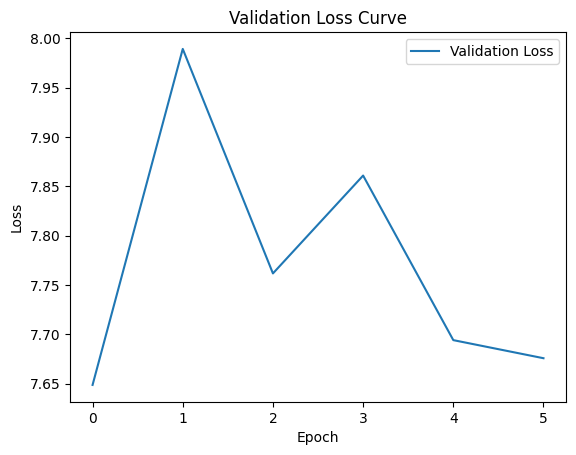

In [24]:

import matplotlib.pyplot as plt
# Plot the validation loss
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss Curve')
plt.legend()
plt.show()


In [25]:
def inverse_transform_synthetic(synthetic_data, scaler, feature_cols):
    """
    Inverse transform the synthetic data to the original scale using the provided scaler and feature names.

    Args:
      synthetic_data: Shape (N, 32) = 30 features + 2 one-hot labels
      scaler: The scaler used for normalization
      feature_cols: List of 30 feature names

    Returns:
      DataFrame with 31 columns (30 features + 'Label')
    """
    # Split features and one-hot labels
    synthetic_features = synthetic_data[:, :30]
    synthetic_labels = synthetic_data[:, 30:]


    # Inverse transform features
    features_original = scaler.inverse_transform(synthetic_features)

    # Convert one-hot to class indices
    labels_original = np.argmax(synthetic_labels, axis=1)


    # Create DataFrame with 30 + 1 columns
    return pd.DataFrame(
        np.hstack([features_original, labels_original[:, None]]),
        columns=feature_cols + ["Label"]  # 30 features + label
    )

In [26]:
# get the proportion of signal labels from the original dataset
s_count = training_higghs_boson_data_original[training_higghs_boson_data_original['Label'] == 's'].shape[0]

# get the proportion of background labels from the original dataset
b_count = training_higghs_boson_data_original[training_higghs_boson_data_original['Label'] == 'b'].shape[0]

# Get the total
total_count = training_higghs_boson_data_original.shape[0]

proportion_s = s_count / total_count # get proportion of signal labels
proportion_b = b_count / total_count # get proportion of background labels

print(f"Proportion of 's' labels: {proportion_s}")
print(f"Proportion of 'b' labels: {proportion_b}")


Proportion of 's' labels: 0.342668
Proportion of 'b' labels: 0.657332


In [27]:
# ----------------------------
# Generate Samples
# ----------------------------
total_samples = 250000 # number of samples to generate

# same proportion of background samples as the original dataset
b_count = int(total_samples * proportion_b)

# same proportion of signal samples as the original dataset
s_count = total_samples - b_count

# Generate class 0 (background)
background_samples = cvae.generate(b_count, 0).numpy()

# Generate class 1 (signal)
signal_samples = cvae.generate(s_count, 1).numpy()

print(background_samples.shape)
print(signal_samples.shape)

(164333, 30)
(85667, 30)


In [28]:
# Generate samples with proper 32 columns (30 features + 2 one-hot labels)

# signal samples
signal_samples = np.hstack([
    signal_samples,  # 30 features
    np.zeros((s_count, 1)),               # Label=1 (one-hot)
    np.ones((s_count, 1))               # Second one-hot column
])

# background samples
background_samples = np.hstack([
    background_samples,   # 30 features
    np.ones((b_count, 1)),              # Label=0 (one-hot)
    np.zeros((b_count, 1))                # Second one-hot column
])

# Combine and transform
final_df_1 = inverse_transform_synthetic(
    np.vstack([signal_samples, background_samples]),
    scaler,
    feature_cols
)

print("Final DataFrame shape:", final_df_1.shape)  # (2000, 31)

Final DataFrame shape: (250000, 31)


In [29]:
# visualize dataframe
final_df_1

,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,...,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Label
0,-494.169857,205.740969,207.676301,379.648869,-825.904016,-847.899715,-802.410622,1.865097,137.571194,579.352061,...,612.557150,1.359066,166.062619,-25.633575,-18.937775,-855.404610,-792.723038,-799.864712,349.668040,1.0
1,-998.973445,91.247146,48.908106,11.669431,-998.999958,-998.999379,-998.999968,1.526172,10.242947,71.956959,...,123.567390,0.000015,-998.992821,-998.999300,-998.999386,-998.999666,-998.999968,-998.999950,0.001381,1.0
2,-998.988531,120.363241,117.787094,108.996742,-998.992963,-998.977161,-998.991439,2.024109,44.290290,208.647802,...,266.920082,1.169546,49.705156,-9.198522,-6.733638,-998.958356,-998.992963,-998.994044,96.628970,1.0
3,-998.992542,116.596145,114.555641,110.693852,-998.989967,-998.963450,-998.987137,2.016903,41.864091,208.172976,...,264.476223,1.228226,71.662169,-9.301281,-6.775451,-998.936013,-998.990386,-998.991620,99.342770,1.0
4,-181.988194,36.029887,76.898171,2.890060,-998.999999,-998.999876,-998.999999,3.506397,3.127301,60.786881,...,66.168720,0.000015,-998.986624,-998.995367,-998.994401,-998.999967,-998.999999,-998.999998,0.000695,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249995,175.814139,58.360968,59.279484,18.296800,-998.999961,-998.998149,-998.999943,2.541793,17.294287,67.611925,...,130.975444,0.000067,-998.953783,-998.992110,-998.992927,-998.999438,-998.999970,-998.999938,0.004575,0.0
249996,210.021103,86.772698,204.786924,180.429597,-998.895169,-997.010586,-998.716334,2.805352,160.205523,251.038017,...,407.943519,0.006781,-994.342451,-997.745611,-997.913895,-998.326673,-998.871108,-998.881420,1.855719,0.0
249997,12.872831,6.175489,23.782234,64.052239,7.327365,303.249855,13.239471,0.829292,4.479293,281.063716,...,346.506183,2.630441,174.263746,4.199396,2.938090,162.106828,3.476775,2.741614,196.399790,0.0
249998,175.720633,53.400560,96.792049,16.510018,-998.939386,-998.883956,-998.893464,3.043768,16.541253,88.688655,...,152.725386,0.000013,-998.996255,-998.998684,-998.998669,-998.855193,-998.950938,-998.931523,0.002493,0.0


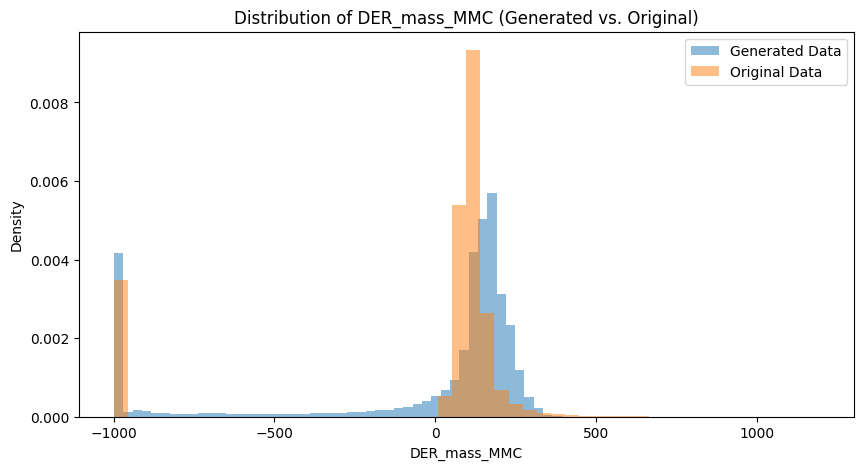

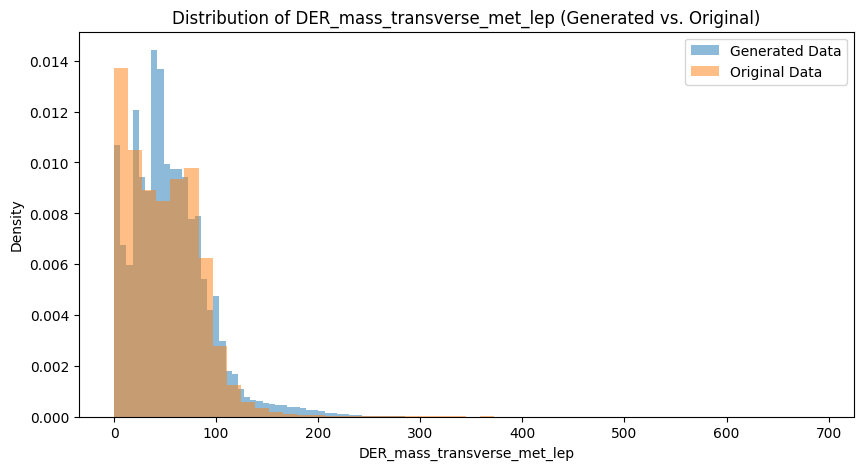

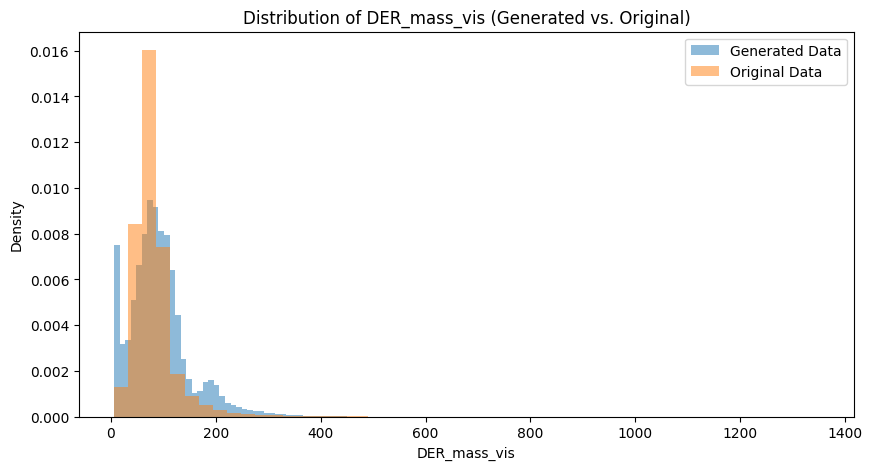

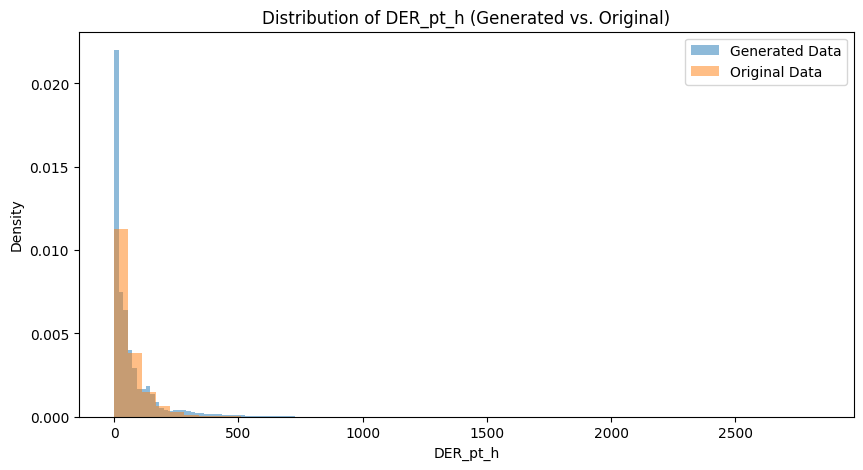

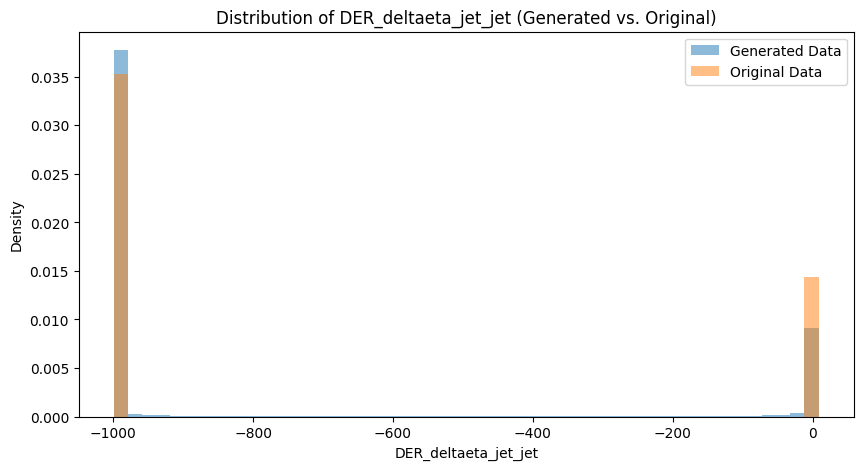

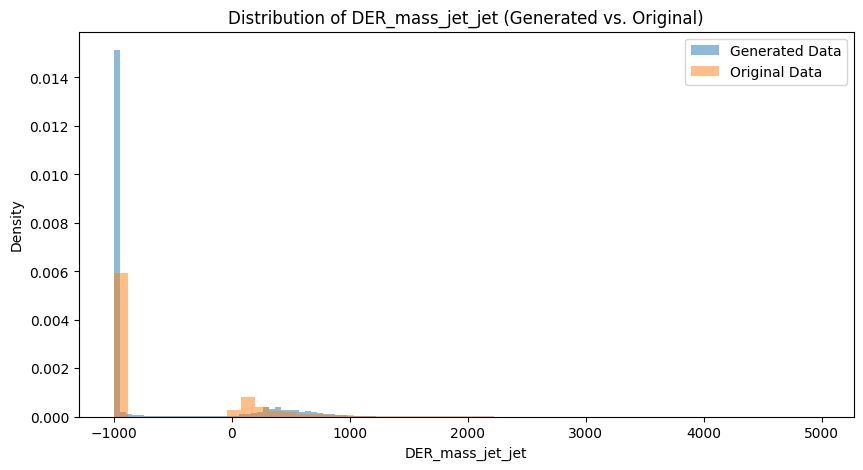

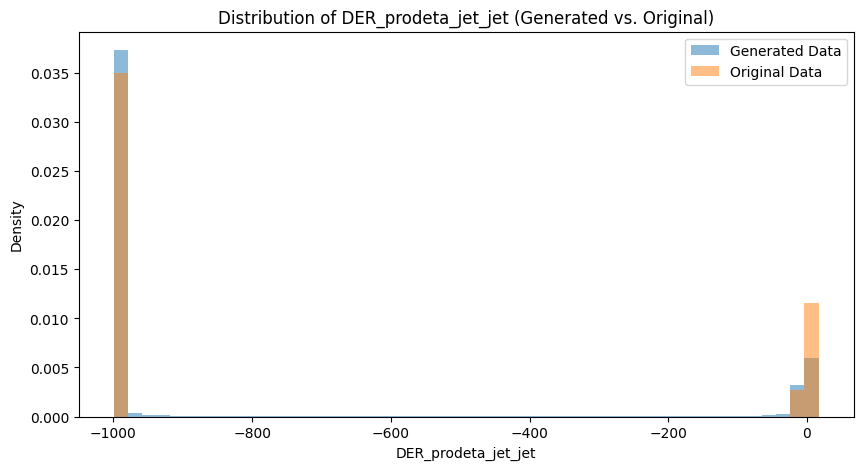

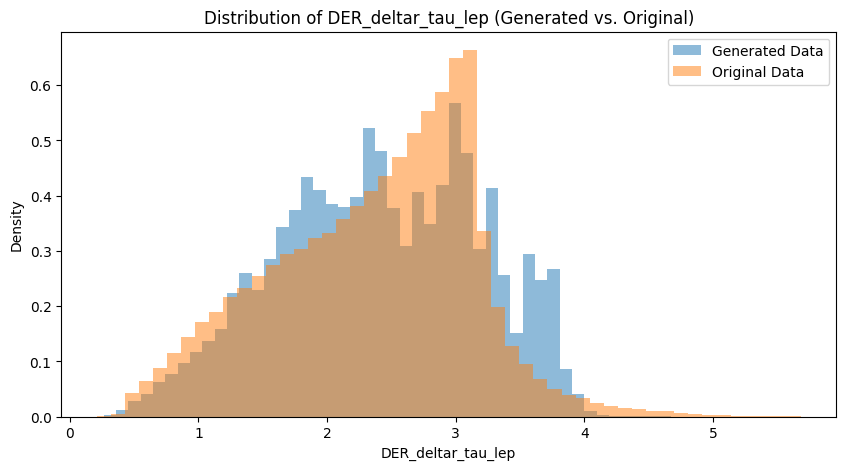

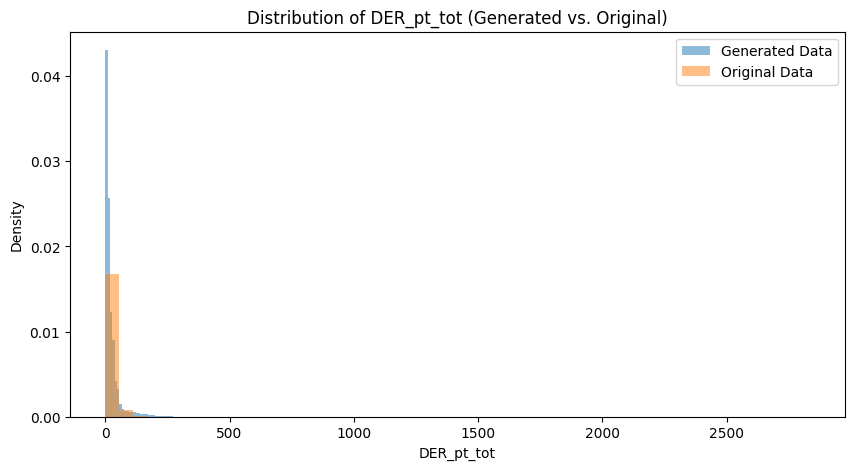

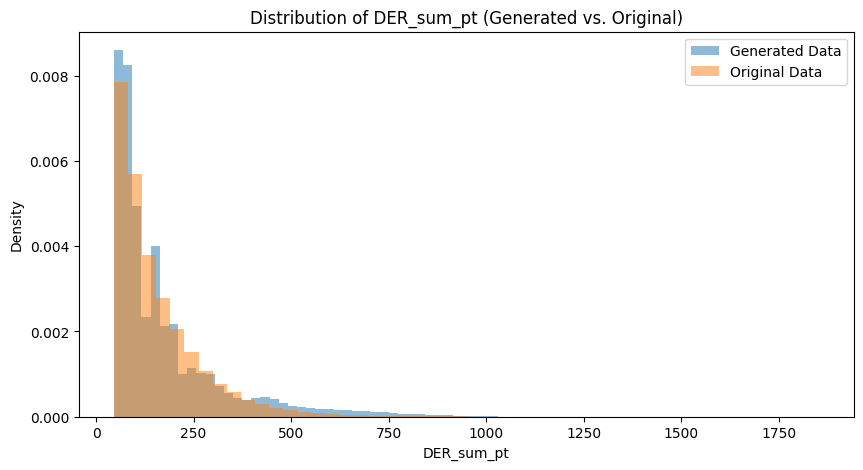

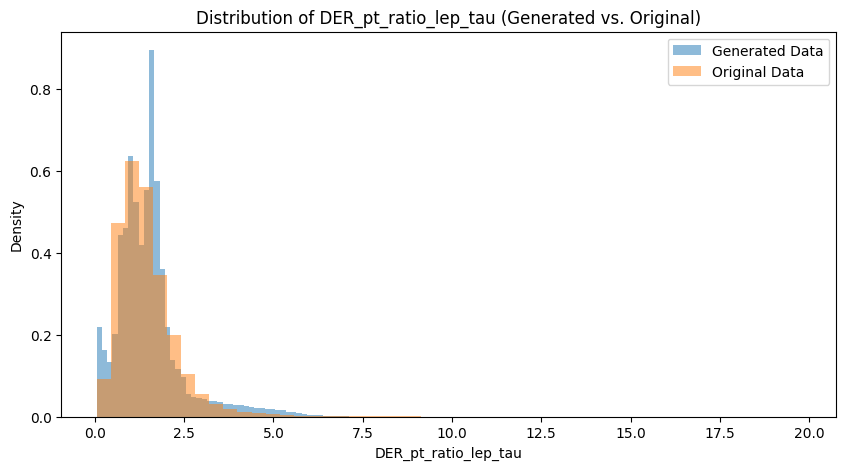

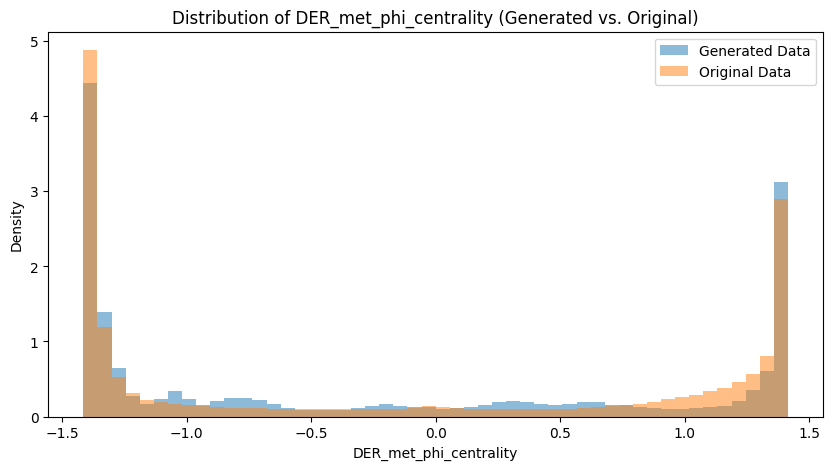

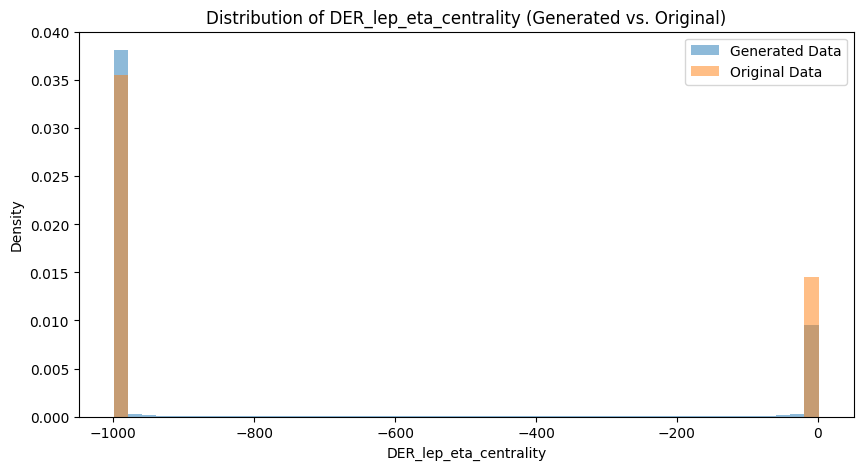

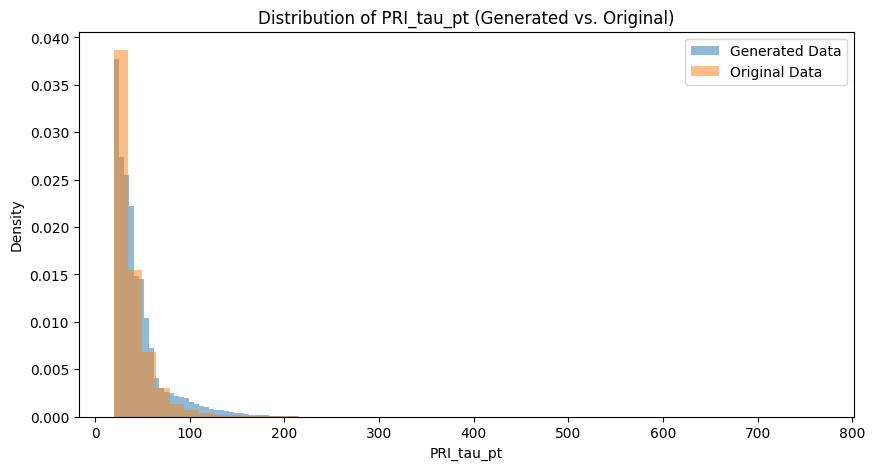

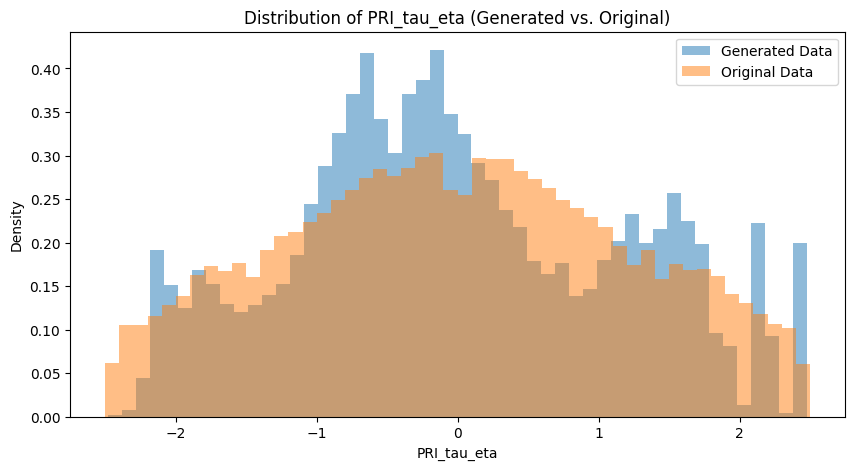

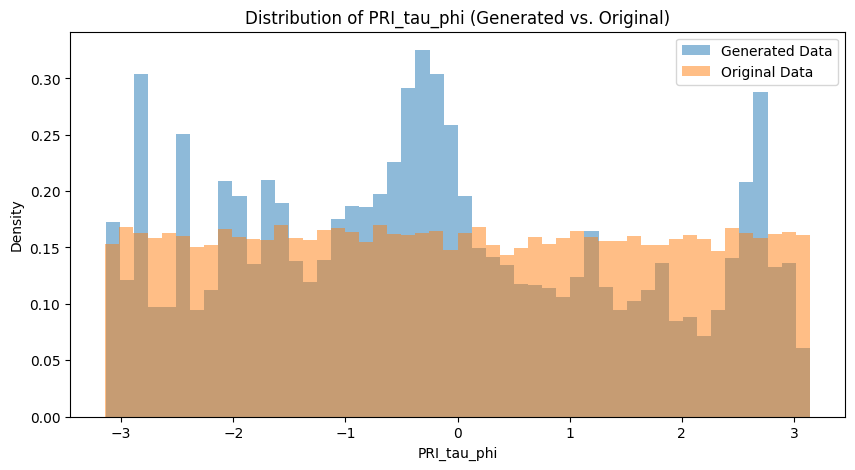

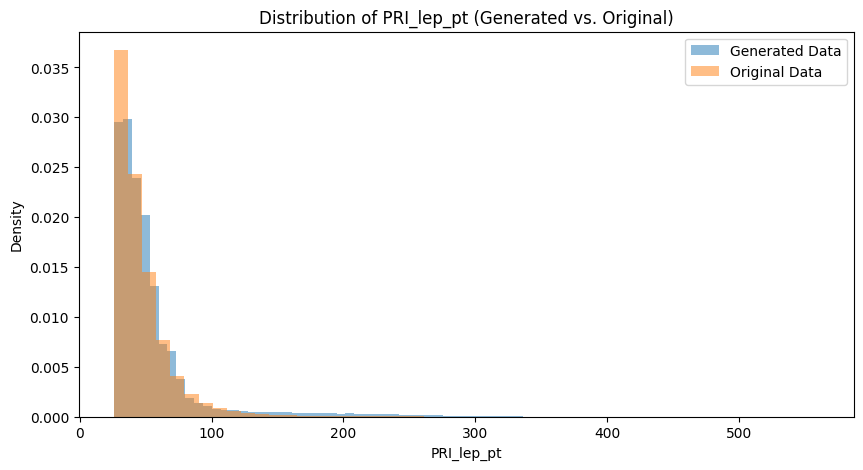

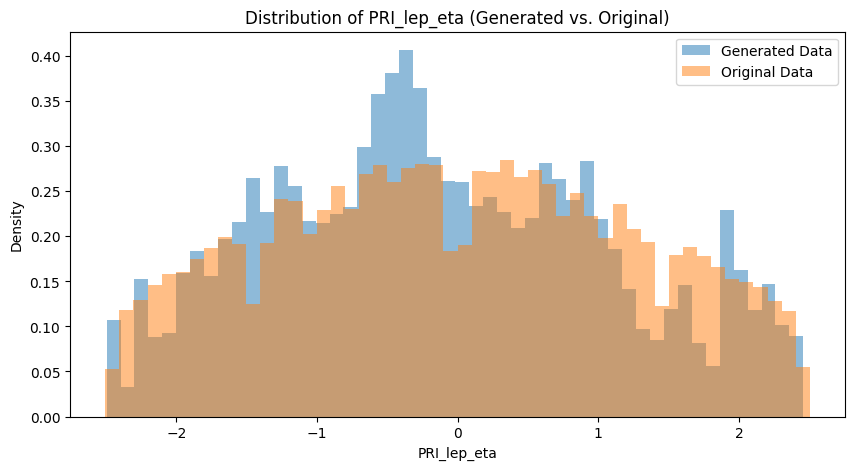

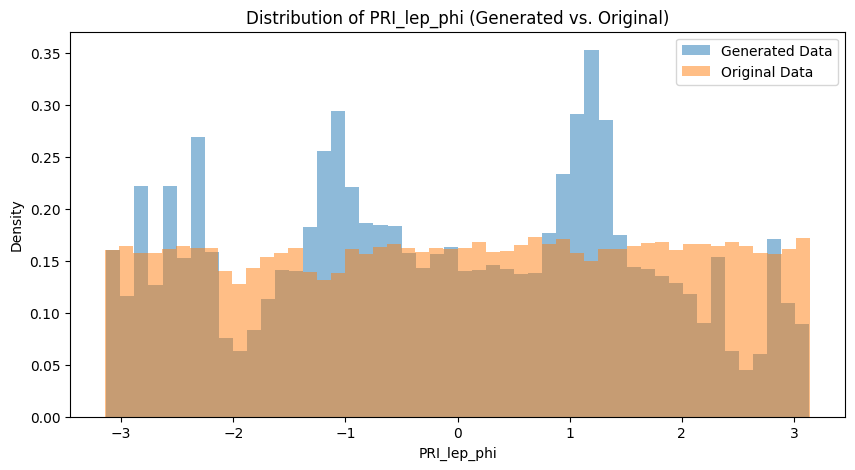

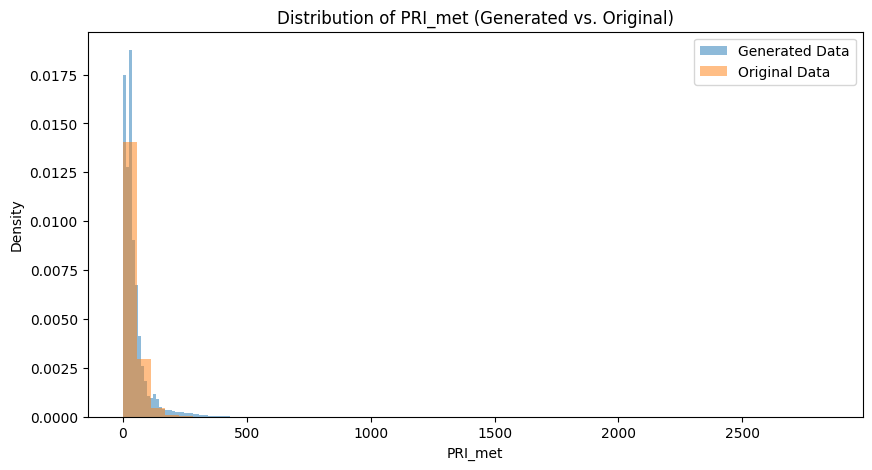

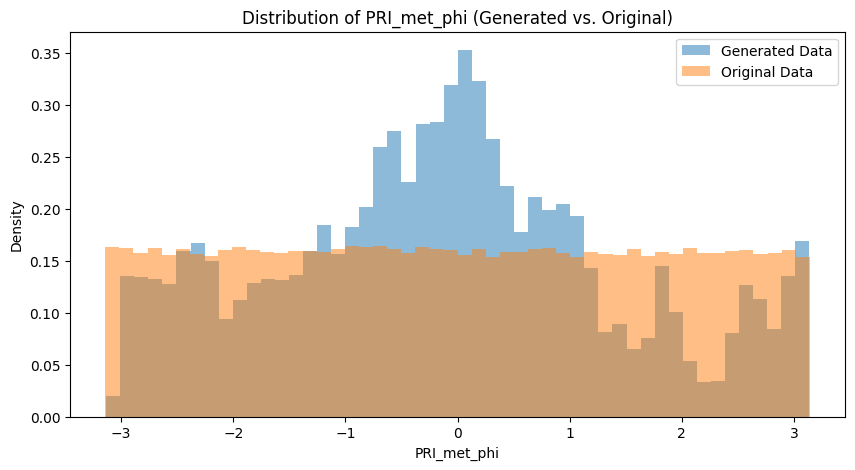

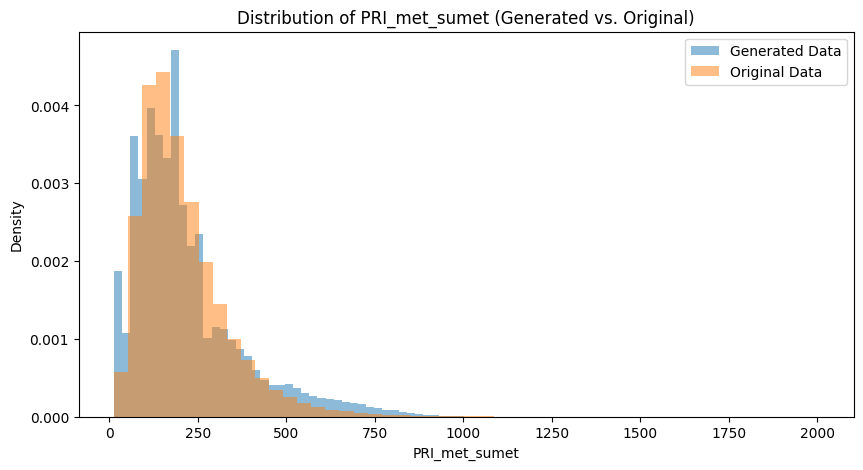

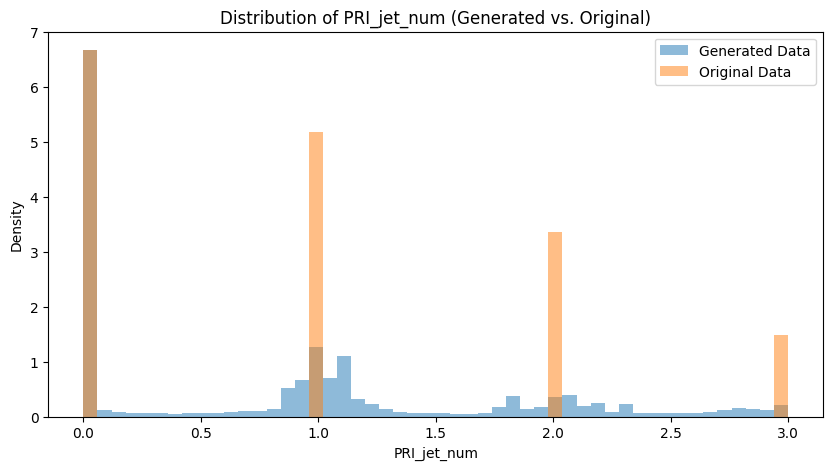

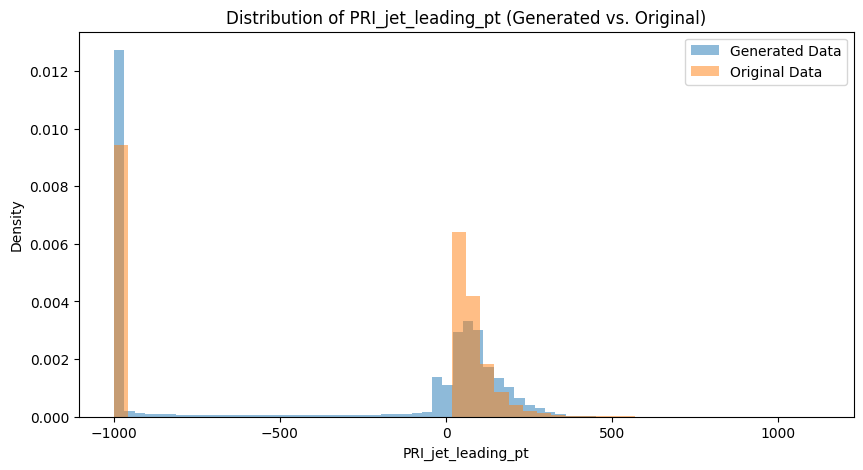

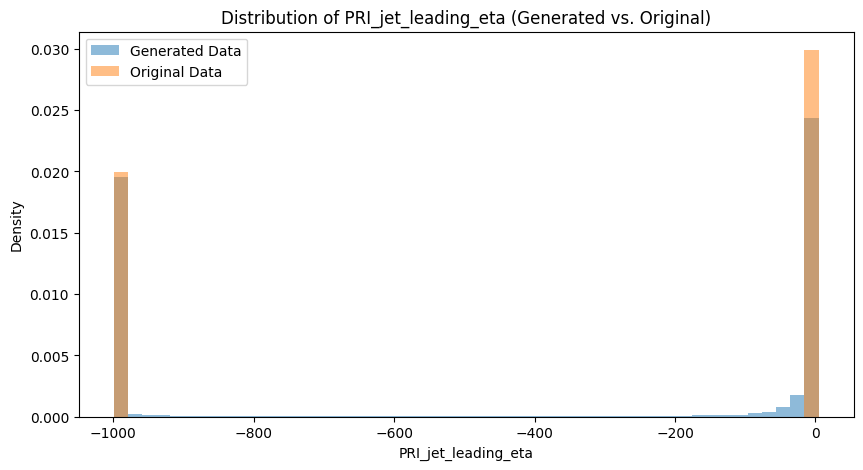

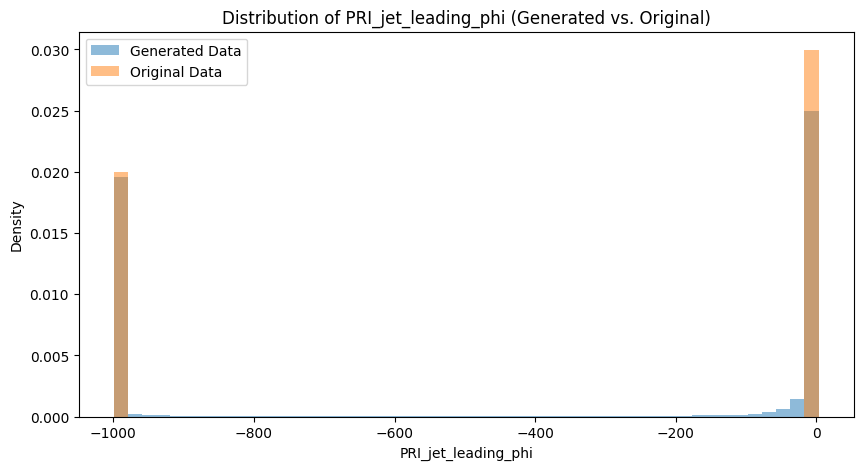

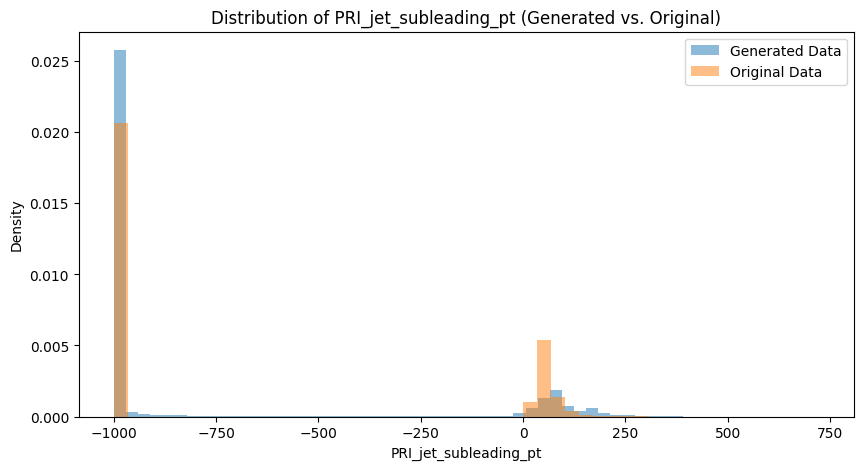

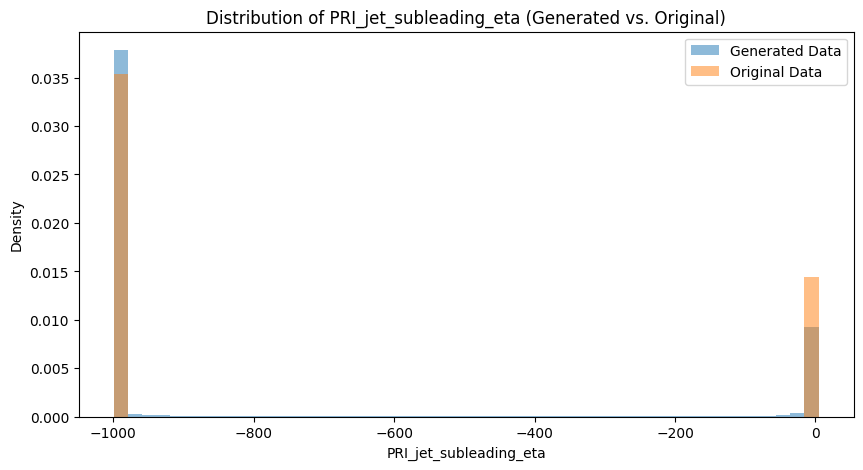

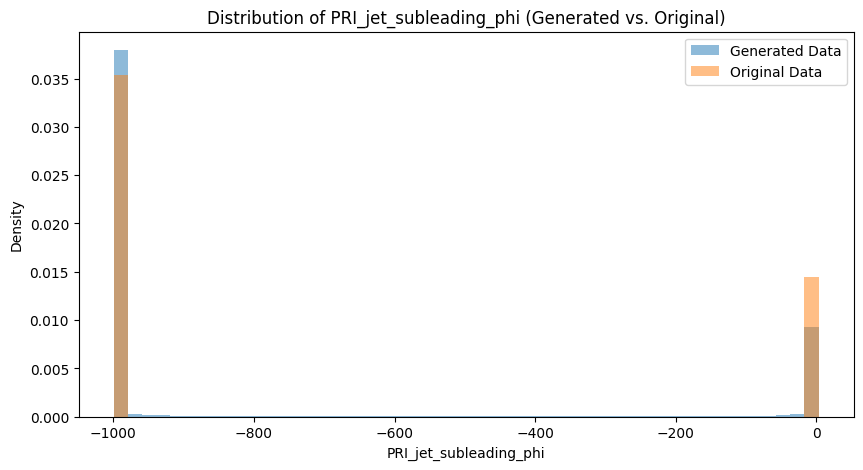

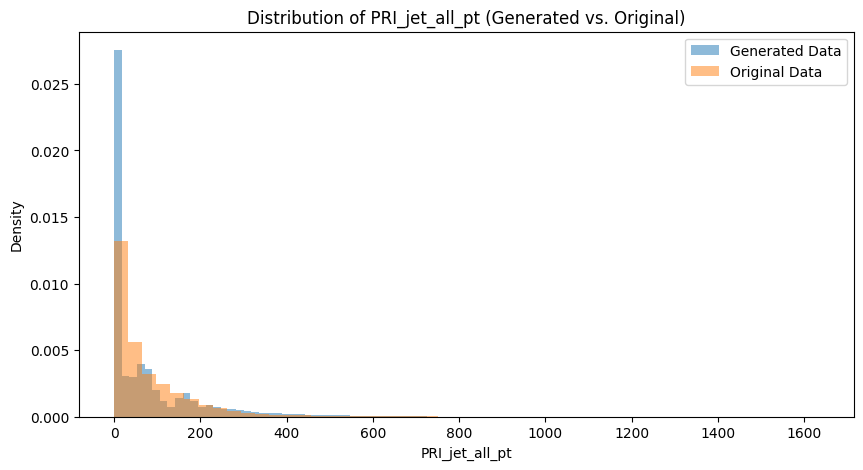

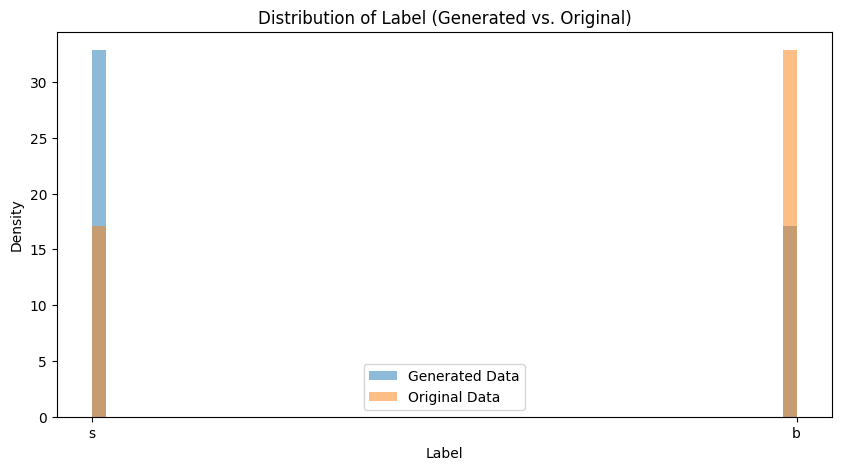

In [30]:
# Plot the distrubution of the real vs synthetic datasets

import matplotlib.pyplot as plt

for col in final_df_1.columns:
    plt.figure(figsize=(10, 5))

    # Plot the distribution of the current column in final_df_1
    plt.hist(final_df_1[col], bins=50, alpha=0.5, label='Generated Data', density=True)

    # Plot the distribution of the same column in training_higghs_boson_data
    plt.hist(training_higghs_boson_data_original[feature_cols + ['Label']][col], bins=50, alpha=0.5, label='Original Data', density=True)

    plt.xlabel(col)
    plt.ylabel('Density')
    plt.title(f'Distribution of {col} (Generated vs. Original)')
    plt.legend()
    plt.show()


As we can see, both distributions resemble, meaning our data generation process works, however, some work is still requiered, maybe fine-tuning the regularizers to allow the latent space to explore more freely the prior distribution for better representations.

# Physics-Informed Neural Networks (PINNs) for Higgs Boson Identification

Training models to identify Higgs boson decays in collider data requires not only learning statistical patterns but also enforcing physical consistency (energy conservation, invariant mass constraints). PINNs achieve this by integrating known physics laws directly into the loss function, acting as regularizers to guide the model toward physically plausible predictions. Below, I detail the architecture and physics-informed components of the PINN used for Higgs boson identification.

A PINN combines data-driven learning with physics-based regularization. For Higgs boson identification, the network is trained to classify events as signal (Higgs decay) or background (other processes) and to minimize violations of physical laws (such as conservation of energy, invariant mass constraints).

The total loss function incorporates both supervised classification loss and physics violation penalties of Higgs decay kinematics. Then, the total loss is calculated by combining binary cross-entropy (data classification) and physics violation penalties:

\begin{align*}
\mathcal{L}_{\text{total}} = \mathcal{L}_{\text{classification}} + \lambda_{\text{mass}} \mathcal{L}_{\text{mass}} + \lambda_{\text{angle}} \mathcal{L}_{\text{angle}} + \lambda_{\text{energy}} \mathcal{L}_{\text{energy}}
\end{align*}

The calculation of each loss is designed as follows:

## 1. Classification Loss (${L}_{\text{classification}}$):

Standard binary cross-entropy for signal/background discrimination:
\begin{align*}
\mathcal{L}_{\text{classification}} = -\frac{1}{N} \sum_{i=1}^N \left[ y_i \log \hat{y}_i + (1 - y_i) \log(1 - \hat{y}_i) \right]
\end{align*}

where $𝑦_𝑖$ ∈ {0,1} is the true label (0=background, 1=Higgs), and $\hat{𝑦}_i$ is the predicted probability.



## 2. Physics Regularization Terms

Since the identification of a particle is defined by its mass and its kinematics (momentum and energy), more precisely, by the 4-momentum ($p_{x}, p_{y}, p_{z},E$) [1], these are the features that I chose to align the model's predictions with physics constriaints.

### a. Invariant Mass Constraint ($\mathcal{L}_{\text{mass}}$)

Penalize deviations from the Higgs boson mass for predicted signals 125GeV [1] :

\begin{align*}
\mathcal{L}_{\text{mass}} = \frac{1}{N} \sum_{i=1}^N \mathbb{I}(\hat{y}_i > 0.5) \cdot \left( m_{\text{est}}^{(i)} - 125.0 \right)^2
\end{align*}

where:

- $ \hat{y}_i > 0.5$ = the model's prediction for signal  for the i-th element
- $ m_{\text{est}}^{(i)}$ = the estimated mass (DER_mass_MMC) for the i-th element

### b. Angular Correlation Constraint ($\mathcal{L}_{\text{angle}}$)

The momenta of a particle is measured by a conventional 3D reference frame (x-axis, y-axis and z-axis) of the ATLAS experiment. The z-axis represent the horizontal beam light, while the x-axis and y-axis are the transverse plane. Given that many particles are lost in the z-axis, the measurements focus on the x and y axis (traverse plane).

The momenta of the particles are calculated with the polar angle ($\theta$) in the z-axis, and the azimuthal angle ($\phi$) in the x-y plane. Given that we said that many particles are lost in the z-axis, we are left to work with the transverse plane (x-y axis) which is equivalent to ($\theta$ = $\pi$/2).

Furthermore, considering that the Higgs boson decays into a lepton and a hadronic tau (as given by the Kaggle challenge dataset), and that we have the azimuthal angle of this last two ($\phi_{\tau}$ for the hadronic tau and $\phi_{lep}$ for the lepton), we will use them to reconstruct (identify) the azimuthal angle of the Higgs boson ($\phi_{H}$) to use it as our momenta constraint in the loss function of the PINN model.

Therefore, we get that:

\begin{align*}
\mathcal{L}_{\text{angle}} = \frac{1}{N} \sum_{i=1}^N \mathbb{I}(\hat{y}_i > 0.5) \cdot \left( (\phi_{\tau}^{(i)} - \phi_{\text{lep}}^{(i)})  - \frac{\pi}{2}\right)^2
\end{align*}

where:

- $ \hat{y}_i > 0.5$ = the model's prediction for signal for the i-th element
-  $( \phi_{\tau}^{(i)} - \phi_{\text{lep}}^{(i)})$ = the inferred azimuthal angle of the Higgs boson ($\phi_{H}$) for the i-th element
- $- \frac{\pi}{2}$ = the deviation of $\phi_{H}$ from the x-y plane

### c. Energy Balance Constraint ($\mathcal{L}_{\text{energy}}$)

Given that $E$ = $\sqrt{p^2 + m^2}$, we can compute the energy constraint of the loss function as:

\begin{align*}
\mathcal{L}_{\text{energy}} = \frac{1}{N} \sum_{i=1}^N \mathbb{I}(\hat{y}_i > 0.5) \cdot \left( [(p_{\tau}^{(i)}+p_{lep}^{(i)}) + m_{tr}^{(i)}] - E_{tr}^{(i)} \right)^2
\end{align*}

where:

- $(p_{\tau}^{(i)}+p_{lep}^{(i)}$ = the total transverse momentum given by the sum of the transeverse momentum $\sqrt{p_{x}^2 +p_{y}^2}$ of the hadronic tau (PRI_tau_pt in the dataset) and the transverse momentum $\sqrt{p_{x}^2 +p_{y}^2}$ of the lepton (PRI_lep_pt) of the i-th element
- $m_{tr}$ = The transverse mass $m_{{tr}}(\vec{a},\vec{b}) = \sqrt{(\sqrt{a_{x}^2 + a_{y}^2} + \sqrt{b_{x}^2 + b_{y}^2})^2 - (a_{x} + b_{x})^2 - (a_{y}+b_{y})^2}$ between the missing transverse energy and the lepton  (DER_mass_transverse_met_lep) of the i-th element
- $E_{tr}^{(i)}$ =  the total transverse energy of the i-th element (PRI_met_sumet)


Finally, these losses are regularized to control the level of influence in the total loss given by:

$\lambda_{\text{mass}}$ = 2: Prioritizes mass peaking at 125 GeV.

$\lambda_{\text{angle}}$ = 0.01: Controls angular correlation strictness.

$\lambda_{\text{energy}}$ = 0.01: Balances energy conservation.


\\


Note: as suggested by the Higgs Challenge, the conjunction between physics and data science can advance the analysis and identification of high-energy particles. Me, as a data scientist, inferred the equations behind the constraints to build the Physics-Informed Neural Network model from the documentation provided by the ATLAS experiment for this challenge [1], however, expert-domain is still required to confirm those equations to make sure they reflect real-world quantum behaviour.


[1] [Learning to discover: the Higgs boson machine learning challenge](https://higgsml.lal.in2p3.fr/files/2014/04/documentation_v1.8.pdf)

In [31]:
# new variable for the original dataset to avoid modifying it
original_data = training_higghs_boson_data_original[feature_cols + ['Label']]
original_data

,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,...,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Label
0,138.470,51.655,97.827,27.980,0.91,124.711,2.666,3.064,41.928,197.760,...,258.733,2,67.435,2.150,0.444,46.062,1.24,-2.475,113.497,s
1,160.937,68.768,103.235,48.146,-999.00,-999.000,-999.000,3.473,2.078,125.157,...,164.546,1,46.226,0.725,1.158,-999.000,-999.00,-999.000,46.226,b
2,-999.000,162.172,125.953,35.635,-999.00,-999.000,-999.000,3.148,9.336,197.814,...,260.414,1,44.251,2.053,-2.028,-999.000,-999.00,-999.000,44.251,b
3,143.905,81.417,80.943,0.414,-999.00,-999.000,-999.000,3.310,0.414,75.968,...,86.062,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,-0.000,b
4,175.864,16.915,134.805,16.405,-999.00,-999.000,-999.000,3.891,16.405,57.983,...,53.131,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,0.000,b
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249995,-999.000,71.989,36.548,5.042,-999.00,-999.000,-999.000,1.392,5.042,55.892,...,144.665,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,0.000,b
249996,-999.000,58.179,68.083,22.439,-999.00,-999.000,-999.000,2.585,22.439,50.618,...,80.408,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,-0.000,b
249997,105.457,60.526,75.839,39.757,-999.00,-999.000,-999.000,2.390,22.183,120.462,...,198.907,1,41.992,1.800,-0.166,-999.000,-999.00,-999.000,41.992,s
249998,94.951,19.362,68.812,13.504,-999.00,-999.000,-999.000,3.365,13.504,55.859,...,112.718,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,0.000,b


In [32]:
# convert categorical to dummy variables

# Create mappings for 'b' and 's'
label_mapping = {'b': 0, 's': 1}
reverse_label_mapping = {0: 'b', 1: 's'}

# Map the labels in original_data
original_data['Label'] = original_data['Label'].map(label_mapping)

# print
print(original_data['Label'].unique())


[1 0]


<ipython-input-32-0ec1756632ab>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original_data['Label'] = original_data['Label'].map(label_mapping)


In [33]:
# visualize dataset
original_data.head()

,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,...,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Label
0,138.470,51.655,97.827,27.980,0.91,124.711,2.666,3.064,41.928,197.760,...,258.733,2,67.435,2.150,0.444,46.062,1.24,-2.475,113.497,1
1,160.937,68.768,103.235,48.146,-999.00,-999.000,-999.000,3.473,2.078,125.157,...,164.546,1,46.226,0.725,1.158,-999.000,-999.00,-999.000,46.226,0
2,-999.000,162.172,125.953,35.635,-999.00,-999.000,-999.000,3.148,9.336,197.814,...,260.414,1,44.251,2.053,-2.028,-999.000,-999.00,-999.000,44.251,0
3,143.905,81.417,80.943,0.414,-999.00,-999.000,-999.000,3.310,0.414,75.968,...,86.062,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,-0.000,0
4,175.864,16.915,134.805,16.405,-999.00,-999.000,-999.000,3.891,16.405,57.983,...,53.131,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,0.000,0


In [34]:
# merge original and synthetic datasets
combined_data = pd.concat([final_df_1, original_data], ignore_index=True)
combined_data

,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,...,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Label
0,-494.169857,205.740969,207.676301,379.648869,-825.904016,-847.899715,-802.410622,1.865097,137.571194,579.352061,...,612.557150,1.359066,166.062619,-25.633575,-18.937775,-855.404610,-792.723038,-799.864712,349.668040,1.0
1,-998.973445,91.247146,48.908106,11.669431,-998.999958,-998.999379,-998.999968,1.526172,10.242947,71.956959,...,123.567390,0.000015,-998.992821,-998.999300,-998.999386,-998.999666,-998.999968,-998.999950,0.001381,1.0
2,-998.988531,120.363241,117.787094,108.996742,-998.992963,-998.977161,-998.991439,2.024109,44.290290,208.647802,...,266.920082,1.169546,49.705156,-9.198522,-6.733638,-998.958356,-998.992963,-998.994044,96.628970,1.0
3,-998.992542,116.596145,114.555641,110.693852,-998.989967,-998.963450,-998.987137,2.016903,41.864091,208.172976,...,264.476223,1.228226,71.662169,-9.301281,-6.775451,-998.936013,-998.990386,-998.991620,99.342770,1.0
4,-181.988194,36.029887,76.898171,2.890060,-998.999999,-998.999876,-998.999999,3.506397,3.127301,60.786881,...,66.168720,0.000015,-998.986624,-998.995367,-998.994401,-998.999967,-998.999999,-998.999998,0.000695,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,-999.000000,71.989000,36.548000,5.042000,-999.000000,-999.000000,-999.000000,1.392000,5.042000,55.892000,...,144.665000,0.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,0.000000,0.0
499996,-999.000000,58.179000,68.083000,22.439000,-999.000000,-999.000000,-999.000000,2.585000,22.439000,50.618000,...,80.408000,0.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-0.000000,0.0
499997,105.457000,60.526000,75.839000,39.757000,-999.000000,-999.000000,-999.000000,2.390000,22.183000,120.462000,...,198.907000,1.000000,41.992000,1.800000,-0.166000,-999.000000,-999.000000,-999.000000,41.992000,1.0
499998,94.951000,19.362000,68.812000,13.504000,-999.000000,-999.000000,-999.000000,3.365000,13.504000,55.859000,...,112.718000,0.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,0.000000,0.0


In [35]:
# Verify proportion of signal and background labels for each dataset
print(original_data['Label'].value_counts())
print(final_df_1['Label'].value_counts())
print(combined_data['Label'].value_counts())

Label
0    164333
1     85667
Name: count, dtype: int64
Label
0.0    164333
1.0     85667
Name: count, dtype: int64
Label
0.0    328666
1.0    171334
Name: count, dtype: int64


In [36]:
# create X and y variables
X = combined_data.drop('Label', axis=1)
y = combined_data['Label']

In [37]:
# normalize features
x_normalized = scaler.fit_transform(X)
x_normalized

array([[2.30408102e-01, 2.98142910e-01, 1.49921075e-01, ...,
        2.05557510e-01, 1.98709652e-01, 2.14069411e-01],
       [1.21198600e-05, 1.32227868e-01, 3.17039527e-02, ...,
        3.16501705e-08, 4.99279444e-08, 8.45511579e-07],
       [5.23463723e-06, 1.74420521e-01, 8.29905197e-02, ...,
        7.01198496e-06, 5.94315725e-06, 5.91569841e-02],
       ...,
       [5.04082106e-01, 8.77093070e-02, 5.17564120e-02, ...,
        0.00000000e+00, 0.00000000e+00, 2.57078191e-02],
       [4.99287092e-01, 2.80578198e-02, 4.65241820e-02, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.05432018e-01, 4.80275081e-02, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [38]:
from sklearn.preprocessing import OneHotEncoder

# Split features and labels
X = combined_data.drop('Label', axis=1).values.astype(np.float32)
y = combined_data['Label'].values

# Convert to float32
y_binary = y.astype(np.float32)

# Split data into train/val sets
from sklearn.model_selection import train_test_split
X_train, X_val, y_binary_train, y_binary_val = train_test_split(
    X, y_binary, test_size=0.2, random_state=42
)

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices(
    (X_train.astype(np.float32), y_binary_train)
).batch(512).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices(
    (X_val.astype(np.float32), y_binary_val)
).batch(512).prefetch(tf.data.AUTOTUNE)

In [40]:
# create functions for the physics constraints

def higgs_mass_constraint(inputs, predictions):
    """
    Physics constraint: Signal events should have mass ~125 GeV

    Args:
      inputs: Features
      predictions: Predictions from the model
    Returns:
      MSE loss for the mass constraint

    """
    # Cast inputs to float32 explicitly
    mass = tf.cast(inputs[:, 0], tf.float32) #DER_mass_MMC (mass)
    signal_mask = tf.cast(predictions > 0.5, tf.float32) # mask to select only signal predictions
    target_mass = tf.constant(125.0, dtype=tf.float32) # mass of 125GeV
    return tf.reduce_mean(signal_mask * tf.square(mass - target_mass)) # mass loss

def angular_correlation_constraint(inputs, predictions):
    """
    Angular correlation constraint

    Args:
      inputs: Features
      predictions: Predictions from the model
    Returns:
      MSE loss for the angular correlation constraint

    """
    # Cast all components to float32
    phi_tau = tf.cast(inputs[:, 15], tf.float32) #PRI_tau_phi
    phi_lep = tf.cast(inputs[:, 18], tf.float32) #PRI_lep_phi
    phi_diff = (phi_tau - phi_lep) # azimuthal angle of the Higgs boson
    max_angle = tf.constant(np.pi/2, dtype=tf.float32) # transverse plane (x-y plane)
    # angle loss
    return tf.reduce_mean(
        tf.cast(predictions > 0.5, tf.float32) *
        tf.square(phi_diff - max_angle)
    )

def energy_balance_constraint(inputs, predictions):
    """
    Energy conservation via transverse momentum, transverse mass, and total transverse energy.

    Args:
      inputs: Features
      predictions: Predictions from the model
    Returns:
      MSE loss for the energy balance constraint

    """
    # Cast features to float32
    p_tau = tf.cast(inputs[:, 13], tf.float32)  # PRI_tau_pt
    p_lep = tf.cast(inputs[:, 16], tf.float32)  # PRI_lep_pt
    m_tr = tf.cast(inputs[:, 1], tf.float32)    # DER_mass_transverse_met_lep
    E_tr = tf.cast(inputs[:, 21], tf.float32) # PRI_met_sumet

    # Compute total transverse momentum (p_τ + p_lep)
    p_total = p_tau + p_lep

    # Calculate (p_total + m_inv) - E_tr
    energy_term = (p_total + m_tr) - E_tr

    # Apply signal mask and compute MSE
    signal_mask = tf.cast(predictions > 0.5, tf.float32)

    # energy loss
    return tf.reduce_mean(signal_mask * tf.square(energy_term))

In [41]:
# Create the PINN model

class HiggsPINN(tf.keras.Model):
    '''

    Class for the PINN model


    '''
    def __init__(self):
        '''
        Constructor for the PINN model

        Args:
            None
        Returns:
            None
        '''
        super().__init__()
        self.dense1 = tf.keras.layers.Dense(128, activation='relu') # first layer
        self.dropout1 = tf.keras.layers.Dropout(0.3) # dropout layer
        self.dense2 = tf.keras.layers.Dense(64, activation='relu') # second layer
        self.dense3 = tf.keras.layers.Dense(32, activation='relu') # third layer
        self.output_layer = tf.keras.layers.Dense(1, activation='sigmoid') #output layer

        # Regularizer for the physics constraint
        self.lambda_mass = 2 # regularizer for the mass
        self.lambda_angle = 0.01 # regularizer for the angle
        self.lambda_energy = 0.01 # regularizer for the energy

    def call(self, inputs):
        '''
        Forward pass of the PINN model

        Args:
            inputs: Features
        Returns:
            Predictions from the model
        '''
        x = self.dense1(inputs) # first layer
        x = self.dropout1(x) # dropout layer
        x = self.dense2(x) # second layer
        x = self.dense3(x) # third layer
        return self.output_layer(x) # output layer

In [42]:
class PINNTrainer(tf.keras.Model):
    '''
    Class for the PINN trainer

    '''
    def __init__(self, pinn_model):
        '''
        Constructor for the PINN trainer

        Args:
            pinn_model: PINN model
        Returns:
            None
        '''
        super().__init__()
        self.pinn_model = pinn_model # PINN model
        self.loss_tracker = tf.keras.metrics.Mean(name="loss") # loss
        self.acc_tracker = tf.keras.metrics.BinaryAccuracy(name="acc") # accuracy

    def train_step(self, data):
        '''
        Training step for the PINN model

        Args:
            data: Features and labels
        Returns:
            Dictionary with loss and accuracy

        '''

        # Unpack data (inputs, labels)
        inputs, y_true = data

         # Ensure we're working with float32 tensors
        inputs = tf.cast(inputs, tf.float32)
        y_true = tf.cast(y_true, tf.float32)

        with tf.GradientTape() as tape:
            # Forward pass
            y_pred = self.pinn_model(inputs, training=True)

            # Reshape y_true to match y_pred dimensions
            y_true = tf.expand_dims(y_true, -1)  # Converts (batch_size,) to (batch_size, 1)

            # Classification loss
            classification_loss = tf.keras.losses.binary_crossentropy(y_true, y_pred)

            # Physics constraints
            mass_loss = higgs_mass_constraint(inputs, y_pred) # constraint for the mass
            angle_loss = angular_correlation_constraint(inputs, y_pred) # constraint for the angle
            energy_loss = energy_balance_constraint(inputs, y_pred) # constraint for the energy

            # Total loss
            total_loss = classification_loss + \
                        self.pinn_model.lambda_mass * mass_loss + \
                        self.pinn_model.lambda_angle * angle_loss + \
                        self.pinn_model.lambda_energy * energy_loss
            total_loss = tf.reduce_mean(total_loss)

        # Compute gradients
        grads = tape.gradient(total_loss, self.pinn_model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.pinn_model.trainable_variables))

        # Update metrics
        self.loss_tracker.update_state(total_loss)
        self.acc_tracker.update_state(y_true, y_pred)

        # return losses
        return {
            "loss": self.loss_tracker.result(),
            "accuracy": self.acc_tracker.result(),
            "mass_loss": mass_loss,
            "angle_loss": angle_loss,
            "energy_loss": energy_loss
        }

    def test_step(self, data):
        '''
        Testing step for the PINN model

        Args:
            data: Features and labels
        Returns:
            Dictionary with loss and accuracy

        '''
        # Unpack data (inputs, labels)
        inputs, y_true = data
        y_pred = self.pinn_model(inputs, training=False)

        # Reshape y_true for validation
        y_true = tf.expand_dims(y_true, -1)

        # Classification loss
        classification_loss = tf.keras.losses.binary_crossentropy(y_true, y_pred)

        # Physics constraints
        mass_loss = higgs_mass_constraint(inputs, y_pred) # constraint for the mass
        angle_loss = angular_correlation_constraint(inputs, y_pred) # constraint for the angle
        energy_loss = energy_balance_constraint(inputs, y_pred) # constraint for the energy

        # total loss
        total_loss = classification_loss + \
                    self.pinn_model.lambda_mass * mass_loss + \
                    self.pinn_model.lambda_angle * angle_loss + \
                    self.pinn_model.lambda_energy * energy_loss
        total_loss = tf.reduce_mean(total_loss)

        # update metrics
        self.loss_tracker.update_state(total_loss)
        self.acc_tracker.update_state(y_true, y_pred)

        # return losses
        return {
            "loss": self.loss_tracker.result(),
            "accuracy": self.acc_tracker.result(),
            "mass_loss": mass_loss,
            "angle_loss": angle_loss,
            "energy_loss": energy_loss
        }


In [43]:
# Initialize and compile
pinn = HiggsPINN()
trainer = PINNTrainer(pinn)


trainer.compile(optimizer=tf.keras.optimizers.Adam(0.001))


In [44]:
import random

random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# define early stopping and restore best weights
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True)

# Train with physics constraints
history = trainer.fit(
    train_dataset,
    epochs=50,
    validation_data=val_dataset,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.6370 - angle_loss: 3.2252 - energy_loss: 5710.3579 - loss: 126002.9922 - mass_loss: 62189.4961 - val_accuracy: 0.6294 - val_angle_loss: 5.4265 - val_energy_loss: 7380.6138 - val_loss: 205108.0156 - val_mass_loss: 115694.5312 - learning_rate: 0.0010
Epoch 2/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.6894 - angle_loss: 3.0668 - energy_loss: 5422.4780 - loss: 118729.4375 - mass_loss: 58875.2227 - val_accuracy: 0.7017 - val_angle_loss: 3.9881 - val_energy_loss: 5424.3062 - val_loss: 142501.2188 - val_mass_loss: 85028.5078 - learning_rate: 0.0010
Epoch 3/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7070 - angle_loss: 2.9191 - energy_loss: 5178.3901 - loss: 112436.3672 - mass_loss: 55894.1758 - val_accuracy: 0.7445 - val_angle_loss: 2.4190 - val_energy_loss: 3290.1528 - val_loss: 93009.5781 - val_mass_loss: 51574.6680 - learning_rate: 0.0010
Epoch 4/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accu

Best epoch: 6
Validation accuracy at best epoch: 0.7491700053215027


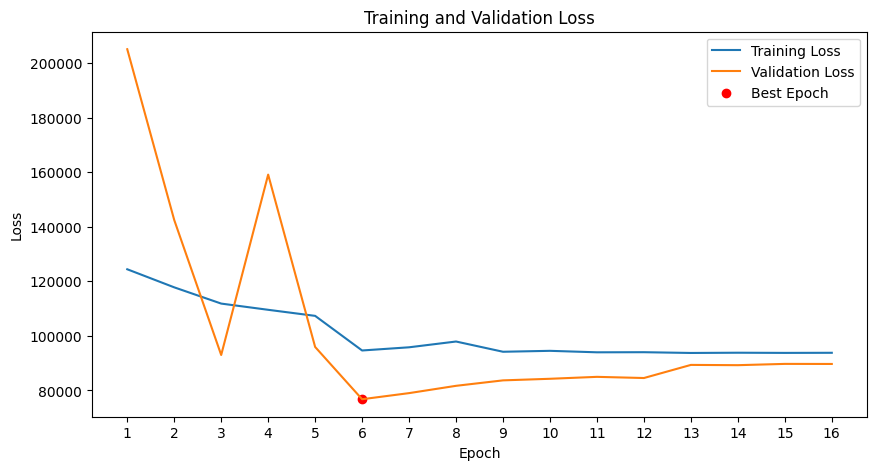

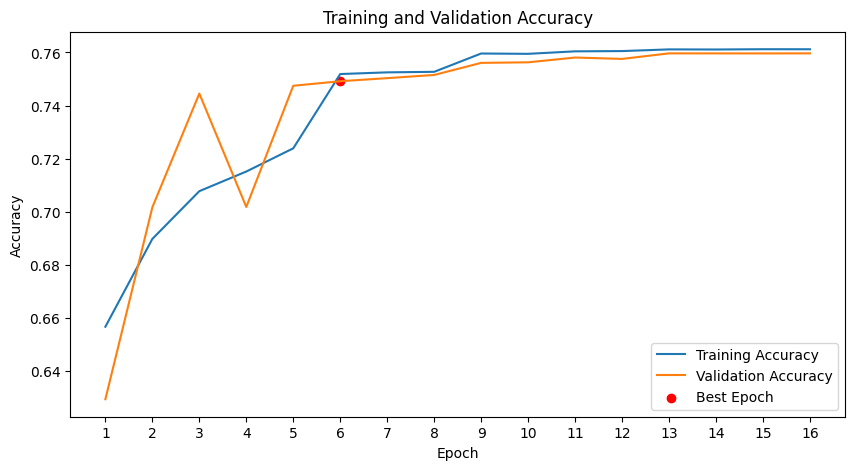

In [45]:
import matplotlib.pyplot as plt
import numpy as np

# Find the epoch with the best validation loss
best_epoch = np.argmin(history.history['val_loss'])

# Print the accuracy of the best epoch
print(f"Best epoch: {best_epoch + 1}")  # Add 1 to match epoch numbering in plots
print(f"Validation accuracy at best epoch: {history.history['val_accuracy'][best_epoch]}") # print validation for the best epoch

# Plot loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(history.history['loss']) + 1), history.history['loss'], label='Training Loss') # Plotting with epoch starting at 1
plt.plot(range(1, len(history.history['val_loss']) + 1), history.history['val_loss'], label='Validation Loss')
# Highlight best epoch on the plot
plt.scatter(best_epoch + 1, history.history['val_loss'][best_epoch], color='r', marker='o', label='Best Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(range(1, len(history.history['val_loss']) + 1))
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(history.history['accuracy']) + 1), history.history['accuracy'], label='Training Accuracy') # Plotting with epoch starting at 1
plt.plot(range(1, len(history.history['val_accuracy']) + 1), history.history['val_accuracy'], label='Validation Accuracy')
# Highlight best epoch on the plot
plt.scatter(best_epoch + 1, history.history['val_accuracy'][best_epoch], color='r', marker='o', label='Best Epoch')
plt.xlabel('Epoch')
plt.xticks(range(1, len(history.history['val_accuracy']) + 1))
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


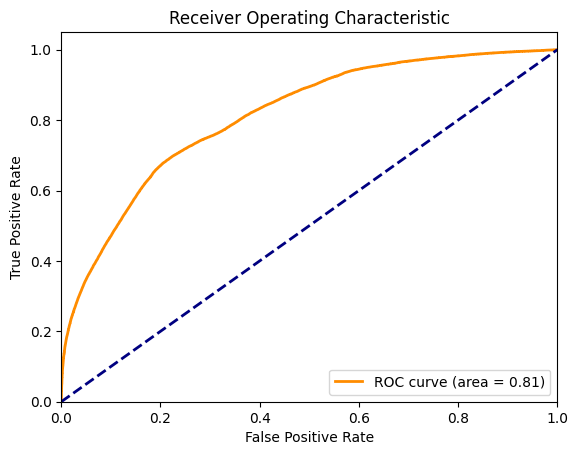

In [46]:
# Plot the area under the curve

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# get the predictions
y_pred_prob = trainer.pinn_model.predict(X_val)

# get the false and true positive rates
fpr, tpr, thresholds = roc_curve(y_binary_val, y_pred_prob)
roc_auc = auc(fpr, tpr) # area under the curve

# plot
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


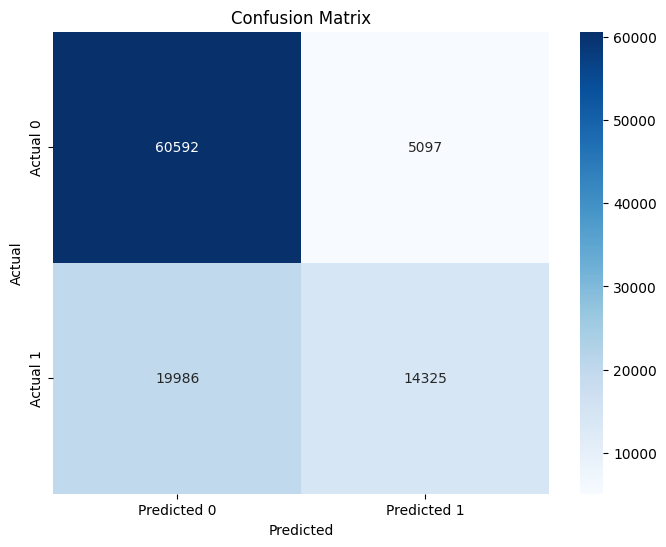

In [47]:
# confusion matrix

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = (y_pred_prob > 0.5).astype(int) # Convert probabilities to class labels

cm = confusion_matrix(y_binary_val, y_pred) # get the confusion matrix

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [49]:
# recall and precision

from sklearn.metrics import recall_score, precision_score

recall = recall_score(y_binary_val, y_pred)
precision = precision_score(y_binary_val, y_pred)

print(f"Recall: {recall}")
print(f"Precision: {precision}")


Recall: 0.4175045903646061
Precision: 0.7375656472042014


In [48]:
# f1 score

from sklearn.metrics import f1_score

f1 = f1_score(y_binary_val, y_pred)
print(f"F1 Score: {f1}")


F1 Score: 0.5331918932499581


# Conclusion

As seen for the metrics, the PINN model does a good work with a validation accuracy of 75% and a ROC curve of 81%, however, there is still room for improvement as confirmed by other metrics like a low recall of 42% meaning that it is not that good at finding Higgs boson but it is decently accurate on its predictions with a precision of 74% resulting in a moderate F1-score of 53% which is also observable in the confusion matrix where there is a high portion predicted as noise (almost 20,000) when in reality, they should be signals of the Higgs boson, contrasting with 14,000 samples that were correctly predicted. These results, specially the precision, show the relevance of the physics constraints, helping the model to accurately identify the Higgs boson, making sure that its outcomes align with the behaviour seen in this particle. Nevertheless, there is still space to grow as previously mentioned, by fine-tuning the hyperparametrs such as the regularization ($\lambda$) of the phsyics constraints that control the influence in the total loss, the incorporation of other constraints, or even modifying the architecture of the model, not to mention the same kind of treatment to the cVampPrior $\beta$-VAE model to improve the creation of synthetic data to better reflect the behaviour of the real one and have higher-quality data to train it.

In summary, these methodologies look promising for the correct simulation and identification of high-energy particles such as the Higgs boson that help us to understand our universe.